# 1 US Stock Market Data  

Using [Yahoo! Finance](https://finance.yahoo.com/) as your data source, download daily prices for S&P 500 and eleven stocks which are part of this index, each representing one of the [GICS](https://www.msci.com/our-solutions/indexes/gics) sectors. You can choose any set of stocks that satisfy these criteria.

Repeat the EDA presented in the lectures. You are most welcome to amend the code as you find fit. It is important that you discuss your results and provide intuition and interpretation for your findings. This analysis should be augmented with the following information for the index and stock returns calculated from closing prices:

In [1]:
# Import / install relevant Python packages
import numpy as np

import pandas as pd     
import pandas_datareader as pdr       # pip install pandas-datareader
from pandas_datareader import wb

import scipy
import scipy.stats as stats
from scipy.stats.mstats import winsorize
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller, kpss
import statsmodels.api as sm

import pylab as py

from sklearn.impute import SimpleImputer

import yfinance as yf                 # pip install yfinance
import wbdata                         # pip install wbdata

import datetime as dt

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
from plotly.subplots import make_subplots

In [2]:
#Define tickers
''' ^GSPC - S&P500
11 random companies from different sectors included in S&P500:
energy - XOM (ExxonMobil) 
materials - BALL (Ball Corporation)
industrials - GE (General Electric)
consumer discretionary - TSLA (Tesla Inc.)
consumer staples - KO (Coca Cola Company)
health care - ABT (Abott)
financials - GS (Goldman Sachs)
information technology - CSCO (Cisco)
communication services - NFLX (Netflix)
utilities - NRG (NRG Energy)
real estate - IRM (Iron Mountain)'''

tickers = ['^GSPC', 'XOM','BALL','GE','TSLA','KO','ABT','GS','CSCO','NFLX','NRG','IRM']
names = ['S&P500', 'ExxonMobil', 'Ball Corporation', 'General Electric', 'Tesla Inc.', 
        'Coca Cola Company', 'Abott', 'Goldman Sachs', 'Cisco', 'Netflix', 'NRG Energy', 'Iron Mountain']

In [3]:
# Define starting and ending date (Format: yyyy,m/mm,d/dd)
#start_date = dt.datetime(2021,1,1)
#end_date   = dt.datetime.today()

##### Data to prices and returns conversion + descriptive info & statistics

In [4]:
# Download data
df_stock_prices = yf.download(tickers,group_by='ticker')
display(df_stock_prices)  

[*********************100%***********************]  12 of 12 completed


IRM                                                         \
                 Open       High        Low      Close  Adj Close     Volume   
Date                                                                           
1950-01-03        NaN        NaN        NaN        NaN        NaN        NaN   
1950-01-04        NaN        NaN        NaN        NaN        NaN        NaN   
1950-01-05        NaN        NaN        NaN        NaN        NaN        NaN   
1950-01-06        NaN        NaN        NaN        NaN        NaN        NaN   
1950-01-09        NaN        NaN        NaN        NaN        NaN        NaN   
...               ...        ...        ...        ...        ...        ...   
2022-09-26  46.240002  46.299999  44.470001  44.730000  44.730000  2487600.0   
2022-09-27  45.230000  45.410000  43.439999  43.590000  43.590000  2436900.0   
2022-09-28  44.090000  45.220001  43.529999  44.910000  44.910000  1573400.0   
2022-09-29  44.400002  44.430000  43.330002  43.810001  43.810001  1541900.0   
2022-09-30  44.599998  44.860001  43.880001  43.970001  43.970001  1509700.0   

                  NFLX                                      ...        XOM  \
                  Open        High         Low       Close  ...        Low   
Date                                                        ...              
1950-01-03         NaN         NaN         NaN         NaN  ...        NaN   
1950-01-04         NaN         NaN         NaN         NaN  ...        NaN   
1950-01-05         NaN         NaN         NaN         NaN  ...        NaN   
1950-01-06         NaN         NaN         NaN         NaN  ...        NaN   
1950-01-09         NaN         NaN         NaN         NaN  ...        NaN   
...                ...         ...         ...         ...  ...        ...   
2022-09-26  225.600006  232.699997  223.009995  224.070007  ...  83.889999   
2022-09-27  228.630005  230.639999  220.720001  224.360001  ...  84.809998   
2022-09-28  229.690002  246.649994  227.380005  245.199997  ...  85.919998   
2022-09-29  241.610001  246.979996  235.679993  239.710007  ...  87.129997   
2022-09-30  237.000000  242.440002  233.259995  235.440002  ...  87.309998   

                                                     KO                        \
                Close  Adj Close      Volume       Open       High        Low   
Date                                                                            
1950-01-03        NaN        NaN         NaN        NaN        NaN        NaN   
1950-01-04        NaN        NaN         NaN        NaN        NaN        NaN   
1950-01-05        NaN        NaN         NaN        NaN        NaN        NaN   
1950-01-06        NaN        NaN         NaN        NaN        NaN        NaN   
1950-01-09        NaN        NaN         NaN        NaN        NaN        NaN   
...               ...        ...         ...        ...        ...        ...   
2022-09-26  83.980003  83.980003  22043400.0  58.490002  58.570000  57.689999   
2022-09-27  85.739998  85.739998  17307300.0  58.080002  58.369999  56.310001   
2022-09-28  88.860001  88.860001  19543300.0  56.660000  57.250000  55.910000   
2022-09-29  88.680000  88.680000  17896000.0  57.090000  57.290001  56.000000   
2022-09-30  87.309998  87.309998  21344700.0  56.869999  57.130001  56.000000   

                                              
                Close  Adj Close      Volume  
Date                                          
1950-01-03        NaN        NaN         NaN  
1950-01-04        NaN        NaN         NaN  
1950-01-05        NaN        NaN         NaN  
1950-01-06        NaN        NaN         NaN  
1950-01-09        NaN        NaN         NaN  
...               ...        ...         ...  
2022-09-26  57.869999  57.869999  18670100.0  
2022-09-27  56.380001  56.380001  23829300.0  
2022-09-28  56.980000  56.980000  21480100.0  
2022-09-29  56.570000  56.570000  14570700.0  
2022-09-30  56.020000  56.020000  16119200.0  

[18306 row

In [5]:
# Get high-level info: Aggregated view
df_stock_prices.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 18306 entries, 1950-01-03 to 2022-09-30
Data columns (total 72 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   (IRM, Open)         6713 non-null   float64
 1   (IRM, High)         6713 non-null   float64
 2   (IRM, Low)          6713 non-null   float64
 3   (IRM, Close)        6713 non-null   float64
 4   (IRM, Adj Close)    6713 non-null   float64
 5   (IRM, Volume)       6713 non-null   float64
 6   (NFLX, Open)        5126 non-null   float64
 7   (NFLX, High)        5126 non-null   float64
 8   (NFLX, Low)         5126 non-null   float64
 9   (NFLX, Close)       5126 non-null   float64
 10  (NFLX, Adj Close)   5126 non-null   float64
 11  (NFLX, Volume)      5126 non-null   float64
 12  (^GSPC, Open)       18306 non-null  float64
 13  (^GSPC, High)       18306 non-null  float64
 14  (^GSPC, Low)        18306 non-null  float64
 15  (^GSPC, Close)      18306 non-null  

In [6]:
# Get high-level info: Segmented view
for iticker in tickers:
    print(iticker)
    df_stock_prices[iticker].info()
    print('-'*100)

^GSPC
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 18306 entries, 1950-01-03 to 2022-09-30
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       18306 non-null  float64
 1   High       18306 non-null  float64
 2   Low        18306 non-null  float64
 3   Close      18306 non-null  float64
 4   Adj Close  18306 non-null  float64
 5   Volume     18306 non-null  int64  
dtypes: float64(5), int64(1)
memory usage: 1001.1 KB
----------------------------------------------------------------------------------------------------
XOM
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 18306 entries, 1950-01-03 to 2022-09-30
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       15293 non-null  float64
 1   High       15293 non-null  float64
 2   Low        15293 non-null  float64
 3   Close      15293 non-null  float64
 4   Adj Close  15293 non-

In [7]:
# Get basic descriptive statistics
df_stock_prices.describe()

IRM                                                      \
              Open         High          Low        Close    Adj Close   
count  6713.000000  6713.000000  6713.000000  6713.000000  6713.000000   
mean     23.628251    23.888013    23.359709    23.636045    14.496227   
std      11.591865    11.703169    11.476630    11.593341    10.994118   
min       2.510212     2.601492     2.510212     2.510212     1.121688   
25%      12.926679    13.082769    12.778805    12.939002     5.781792   
50%      25.175600    25.452866    24.889999    25.157116    11.518153   
75%      31.879999    32.139999    31.549999    31.857672    22.081249   
max      58.000000    58.610001    57.500000    57.720001    56.337589   

                            NFLX                                         ...  \
             Volume         Open         High          Low        Close  ...   
count  6.713000e+03  5126.000000  5126.000000  5126.000000  5126.000000  ...   
mean   1.339122e+06   118.003860   119.830376   116.081666   118.007485  ...   
std    1.445328e+06   167.847418   170.254616   165.236225   167.784407  ...   
min    0.000000e+00     0.377857     0.410714     0.346429     0.372857  ...   
25%    4.764320e+05     3.976428     4.073214     3.907857     3.987500  ...   
50%    1.049500e+06    26.913571    27.445001    26.452857    26.896428  ...   
75%    1.769900e+06   176.069996   179.759998   172.619995   176.259998  ...   
max    3.574549e+07   692.349976   700.989990   686.090027   691.690002  ...   

                XOM                                                      KO  \
                Low         Close     Adj Close        Volume          Open   
count  15293.000000  15293.000000  15293.000000  1.529300e+04  15293.000000   
mean      30.671340     30.968155     19.326254  9.222478e+06     16.647249   
std       31.769595     32.062051     23.868037  9.514180e+06     17.608883   
min        1.417969      1.437500      0.092976  1.760000e+05      0.192708   
25%        3.023438      3.046875      0.413499  2.595200e+06      0.867188   
50%       14.718750     14.843750      5.619543  6.104000e+06     10.000000   
75%       59.540001     60.090000     38.447380  1.240800e+07     29.500000   
max      103.949997    104.589996    103.583549  1.180235e+08     67.000000   

                                                                             
               High           Low         Close     Adj Close        Volume  
count  15293.000000  15293.000000  15293.000000  15293.000000  1.529300e+04  
mean      16.784659     16.507482     16.651886     11.763331  9.131464e+06  
std       17.740982     17.473766     17.611484     14.958159  7.958196e+06  
min        0.193359      0.182292      0.192057      0.037028  7.680000e+04  
25%        0.872396      0.859375      0.867188      0.238111  2.884800e+06  
50%       10.109375      9.906250     10.000000      4.926925  7.699200e+06  
75%       29.843750     29.200001     29.531250     17.382875  1.304360e+07  
max       67.199997     65.720001     66.209999     65.259277  1.241690e+08  

[8 rows x 72 columns]

In [8]:
# Creating a data frame consisting of stock returns
fields_prices    = ['Open', 'High', 'Low', 'Close', 'Adj Close']
fields_all       = df_stock_prices.columns.get_level_values(1).drop_duplicates().tolist()
fields_drop      = list(set(fields_all) - set(fields_prices))
print(fields_all)
print(fields_drop)

df_stock_returns = df_stock_prices.copy()
df_stock_returns = df_stock_returns.drop(fields_drop, level=1, axis=1)
df_stock_returns = df_stock_returns.pct_change(fill_method=None)
display(df_stock_returns)

['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume']
['Volume']


IRM                                              NFLX  \
                Open      High       Low     Close Adj Close      Open   
Date                                                                     
1950-01-03       NaN       NaN       NaN       NaN       NaN       NaN   
1950-01-04       NaN       NaN       NaN       NaN       NaN       NaN   
1950-01-05       NaN       NaN       NaN       NaN       NaN       NaN   
1950-01-06       NaN       NaN       NaN       NaN       NaN       NaN   
1950-01-09       NaN       NaN       NaN       NaN       NaN       NaN   
...              ...       ...       ...       ...       ...       ...   
2022-09-26 -0.021997 -0.025468 -0.036403 -0.040129 -0.040129 -0.040572   
2022-09-27 -0.021843 -0.019222 -0.023162 -0.025486 -0.025486  0.013431   
2022-09-28 -0.025204 -0.004184  0.002072  0.030282  0.030282  0.004636   
2022-09-29  0.007031 -0.017470 -0.004594 -0.024493 -0.024493  0.051896   
2022-09-30  0.004504  0.009678  0.012693  0.003652  0.003652 -0.019080   

                                                    ...       XOM            \
                High       Low     Close Adj Close  ...      Open      High   
Date                                                ...                       
1950-01-03       NaN       NaN       NaN       NaN  ...       NaN       NaN   
1950-01-04       NaN       NaN       NaN       NaN  ...       NaN       NaN   
1950-01-05       NaN       NaN       NaN       NaN  ...       NaN       NaN   
1950-01-06       NaN       NaN       NaN       NaN  ...       NaN       NaN   
1950-01-09       NaN       NaN       NaN       NaN  ...       NaN       NaN   
...              ...       ...       ...       ...  ...       ...       ...   
2022-09-26 -0.015860  0.007135 -0.010335 -0.010335  ... -0.029714 -0.014629   
2022-09-27 -0.008853 -0.010269  0.001294  0.001294  ...  0.008363  0.008583   
2022-09-28  0.069416  0.030174  0.092886  0.092886  ...  0.005957  0.026909   
2022-09-29  0.001338  0.036503 -0.022390 -0.022390  ...  0.023920  0.000672   
2022-09-30 -0.018382 -0.010268 -0.017813 -0.017813  ... -0.000113 -0.003581   

                                                KO                      \
                 Low     Close Adj Close      Open      High       Low   
Date                                                                     
1950-01-03       NaN       NaN       NaN       NaN       NaN       NaN   
1950-01-04       NaN       NaN       NaN       NaN       NaN       NaN   
1950-01-05       NaN       NaN       NaN       NaN       NaN       NaN   
1950-01-06       NaN       NaN       NaN       NaN       NaN       NaN   
1950-01-09       NaN       NaN       NaN       NaN       NaN       NaN   
...              ...       ...       ...       ...       ...       ...   
2022-09-26 -0.011314 -0.020641 -0.020641 -0.007971 -0.008968 -0.005345   
2022-09-27  0.010967  0.020957  0.020957 -0.007010 -0.003415 -0.023921   
2022-09-28  0.013088  0.036389  0.036389 -0.024449 -0.019188 -0.007104   
2022-09-29  0.014083 -0.002026 -0.002026  0.007589  0.000699  0.001610   
2022-09-30  0.002066 -0.015449 -0.015449 -0.003854 -0.002793  0.000000   

                                
               Close Adj Close  
Date                            
1950-01-03       NaN       NaN  
1950-01-04       NaN       NaN  
1950-01-05       NaN       NaN  
1950-01-06       NaN       NaN  
1950-01-09       NaN       NaN  
...              ...       ...  
2022-09-26 -0.012457 -0.012457  
2022-09-27 -0.025747 -0.025747  
2022-09-28  0.010642  0.010642  
2022-09-29 -0.007196 -0.007196  
2022-09-30 -0.009722 -0.009722  

[18306 rows x 60 columns]

In [9]:
# Get basic info
df_stock_returns.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 18306 entries, 1950-01-03 to 2022-09-30
Data columns (total 60 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   (IRM, Open)         6712 non-null   float64
 1   (IRM, High)         6712 non-null   float64
 2   (IRM, Low)          6712 non-null   float64
 3   (IRM, Close)        6712 non-null   float64
 4   (IRM, Adj Close)    6712 non-null   float64
 5   (NFLX, Open)        5125 non-null   float64
 6   (NFLX, High)        5125 non-null   float64
 7   (NFLX, Low)         5125 non-null   float64
 8   (NFLX, Close)       5125 non-null   float64
 9   (NFLX, Adj Close)   5125 non-null   float64
 10  (^GSPC, Open)       13239 non-null  float64
 11  (^GSPC, High)       18305 non-null  float64
 12  (^GSPC, Low)        18305 non-null  float64
 13  (^GSPC, Close)      18305 non-null  float64
 14  (^GSPC, Adj Close)  18305 non-null  float64
 15  (ABT, Open)         9956 non-null   

In [10]:
# Get basic descriptive statistics
df_stock_returns.describe()

IRM                                                      \
              Open         High          Low        Close    Adj Close   
count  6712.000000  6712.000000  6712.000000  6712.000000  6712.000000   
mean      0.000613     0.000582     0.000585     0.000609     0.000728   
std       0.020468     0.018973     0.019016     0.020303     0.020247   
min      -0.172434    -0.147050    -0.182060    -0.160714    -0.160714   
25%      -0.009009    -0.007491    -0.007193    -0.008470    -0.008317   
50%       0.000000     0.000000     0.000238     0.000000     0.000000   
75%       0.009850     0.007689     0.008865     0.009527     0.009676   
max       0.212094     0.225022     0.184610     0.200537     0.200537   

              NFLX                                                      ...  \
              Open         High          Low        Close    Adj Close  ...   
count  5125.000000  5125.000000  5125.000000  5125.000000  5125.000000  ...   
mean      0.001733     0.001587     0.001633     0.001685     0.001685  ...   
std       0.037233     0.033465     0.034106     0.035959     0.035959  ...   
min      -0.424885    -0.350847    -0.414118    -0.409065    -0.409065  ...   
25%      -0.014809    -0.012729    -0.011556    -0.014391    -0.014391  ...   
50%       0.000081     0.000000     0.002162     0.000321     0.000321  ...   
75%       0.017196     0.013822     0.015306     0.017044     0.017044  ...   
max       0.482446     0.436675     0.439085     0.422235     0.422235  ...   

                XOM                                                          \
               Open          High           Low         Close     Adj Close   
count  1.330600e+04  15292.000000  15292.000000  15292.000000  15292.000000   
mean            inf      0.000341      0.000355      0.000368      0.000547   
std             NaN      0.012451      0.013580      0.014537      0.014442   
min   -1.770618e-01     -0.157935     -0.290230     -0.234286     -0.234286   
25%   -7.180255e-03     -0.006105     -0.005964     -0.007135     -0.006910   
50%    0.000000e+00      0.000000      0.000000      0.000000      0.000000   
75%    8.064516e-03      0.006609      0.006712      0.007901      0.008030   
max             inf      0.129233      0.174089      0.179104      0.179104   

                 KO                                                          
               Open          High           Low         Close     Adj Close  
count  15292.000000  15292.000000  15292.000000  15292.000000  15292.000000  
mean       0.000450      0.000432      0.000449      0.000457      0.000566  
std        0.013999      0.012826      0.013984      0.014602      0.014582  
min       -0.225000     -0.111111     -0.261146     -0.246914     -0.246914  
25%       -0.006600     -0.005916     -0.005856     -0.006929     -0.006812  
50%        0.000000      0.000000      0.000000      0.000000      0.000000  
75%        0.007246      0.006301      0.006744      0.007481      0.007583  
max        0.290323      0.097223      0.290323      0.196721      0.196721  

[8 rows x 60 columns]

#### Plotting prices, volume, returns & their Simple Moving Averages (SMA) for 60 and 250 days

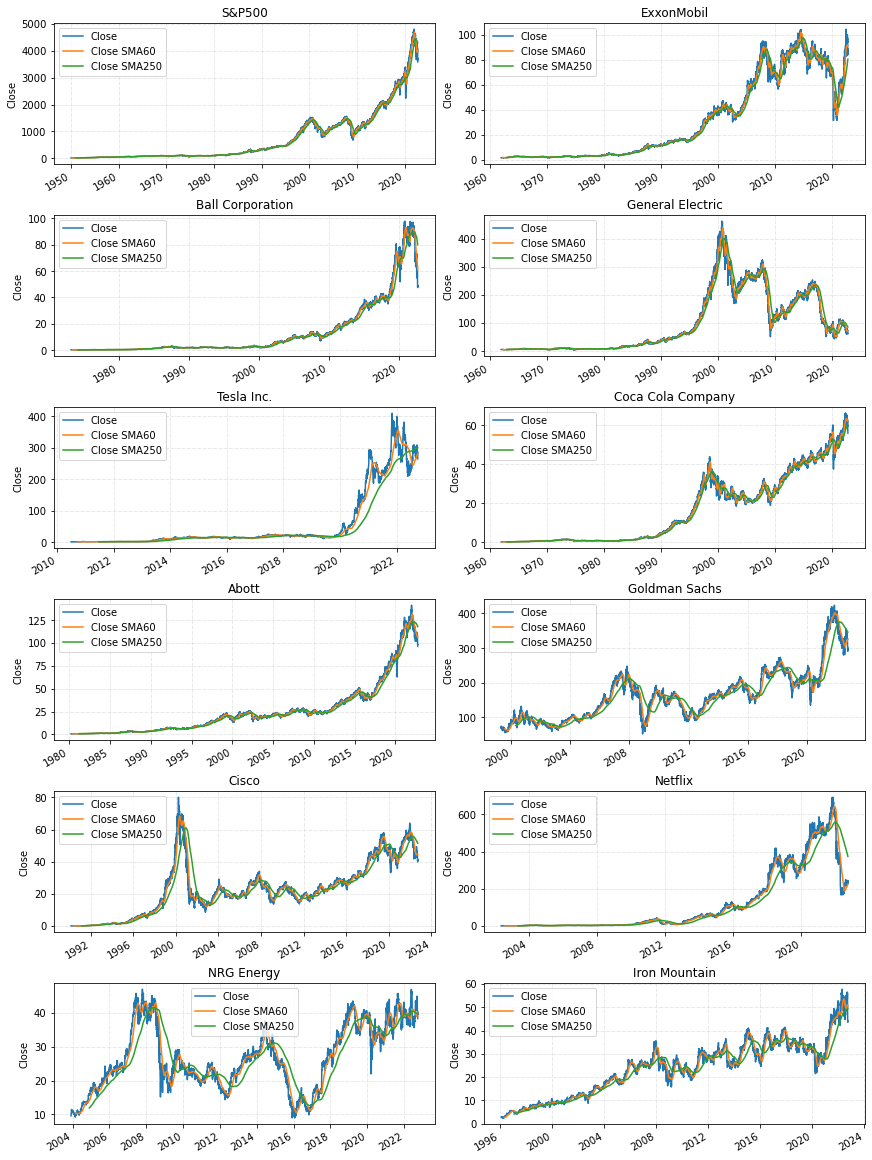

In [11]:
# Plotting closing prices (and simple moving averages)
plt.figure(figsize=(12, 16), constrained_layout = True)
for iticker in range(len(tickers)):
    # Calculate simple moving average (60 and 250 days)
    df_stock_prices[tickers[iticker],'Close SMA60'] = (
        df_stock_prices[tickers[iticker]]['Close'].rolling(60).mean()) 
    df_stock_prices[tickers[iticker],'Close SMA250'] = (
        df_stock_prices[tickers[iticker]]['Close'].rolling(250).mean()) 
    # Create subplots
    plt.subplot(6, 2, iticker+1)
    df_stock_prices[tickers[iticker]]['Close'].plot(linewidth=1.5)
    df_stock_prices[tickers[iticker]]['Close SMA60'].plot(linewidth=1.5)
    df_stock_prices[tickers[iticker]]['Close SMA250'].plot(linewidth=1.5)
    # Labels and graphics
    plt.xlabel(None)
    plt.ylabel('Close')
    plt.title(names[iticker])
    plt.legend(['Close','Close SMA60','Close SMA250'])
    plt.grid(color='lightgray', linestyle='-.', linewidth=0.5)

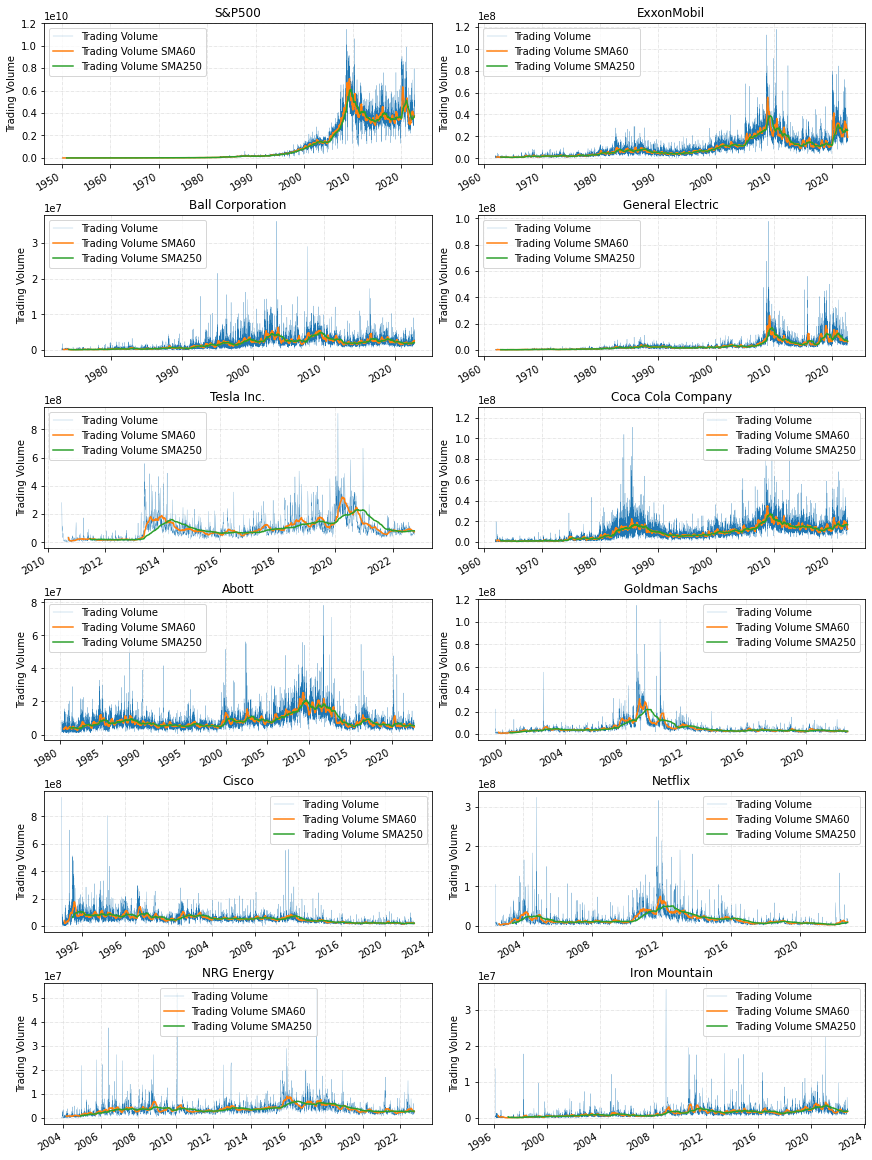

In [12]:
# Plotting trading volume (and simple moving averages)
plt.figure(figsize=(12, 16), constrained_layout = True)

for iticker in range(len(tickers)):
    # Calculate simple moving average (60 and 250 days)
    df_stock_prices[tickers[iticker],'Volume SMA60'] = (
        df_stock_prices[tickers[iticker]]['Volume'].rolling(60).mean()) 
    df_stock_prices[tickers[iticker],'Volume SMA250'] = (
        df_stock_prices[tickers[iticker]]['Volume'].rolling(250).mean()) 
    # Create subplots
    plt.subplot(6, 2, iticker+1)
    df_stock_prices[tickers[iticker]]['Volume'].plot(linewidth=0.2)
    df_stock_prices[tickers[iticker]]['Volume SMA60'].plot(linewidth=1.5)
    df_stock_prices[tickers[iticker]]['Volume SMA250'].plot(linewidth=1.5)
    # Labels and graphics
    plt.xlabel(None)
    plt.ylabel('Trading Volume')
    plt.title(names[iticker])
    plt.legend(['Trading Volume',
                'Trading Volume SMA60',
                'Trading Volume SMA250'])
    plt.grid(color='lightgray', linestyle='-.', linewidth=0.5)

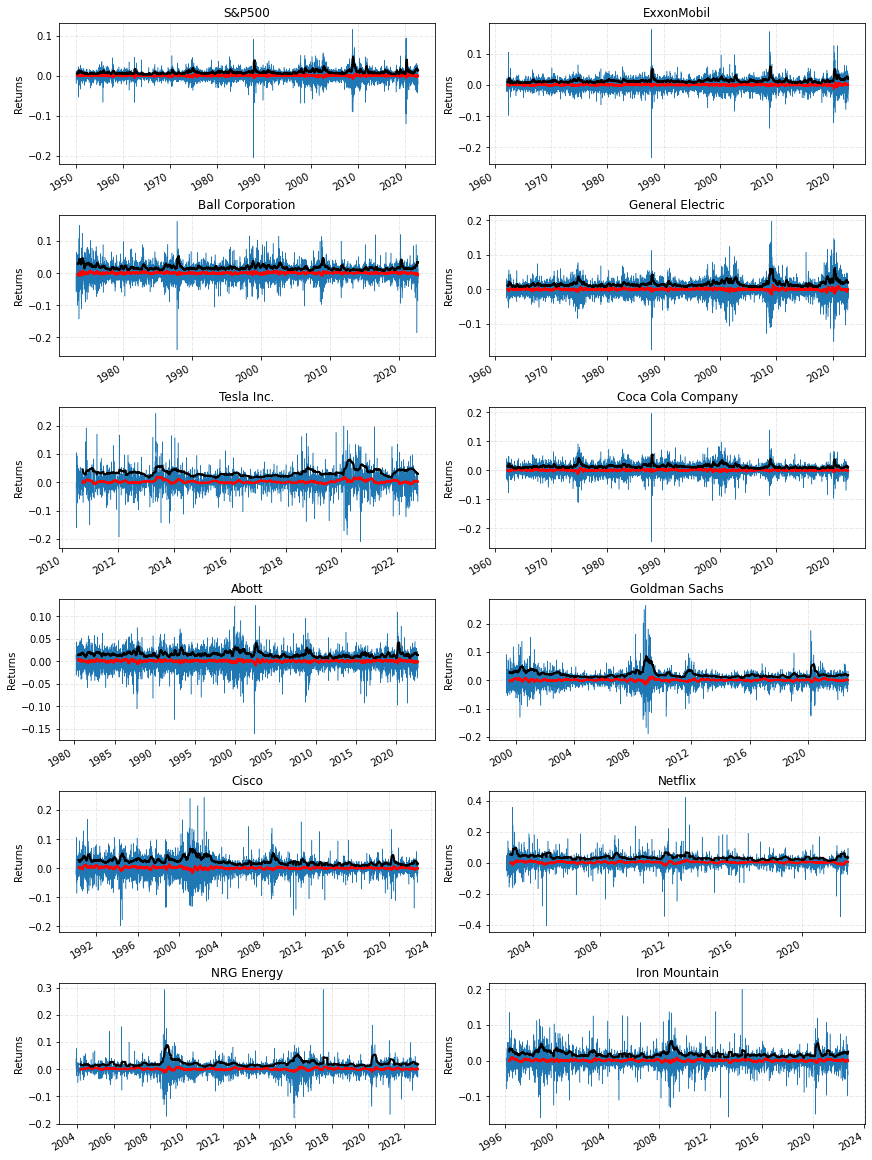

In [13]:
# Plotting returns (calculated from close price)
plt.figure(figsize=(12, 16), constrained_layout = True)

for iticker in range(len(tickers)):
    # Calculate rolling mean and standard deviation
    irollmean =  df_stock_returns[tickers[iticker]]['Close'].rolling(60).mean()
    irollvola =  df_stock_returns[tickers[iticker]]['Close'].rolling(60).std()
    # Create subplots
    plt.subplot(6, 2, iticker+1)
    df_stock_returns[tickers[iticker]]['Close'].plot(linewidth=0.5)
    irollmean.plot(linewidth=2, color='red')
    irollvola.plot(linewidth=2, color='black')
    # Labels and graphics
    plt.xlabel(None)
    plt.ylabel('Returns')
    plt.title(names[iticker])
    plt.grid(color='lightgray', linestyle='-.', linewidth=0.5)

#### Checking for Stationarity - Plotting ACF (AutoCorrelation Function) and PACF (Partial AutoCorrelation Function)

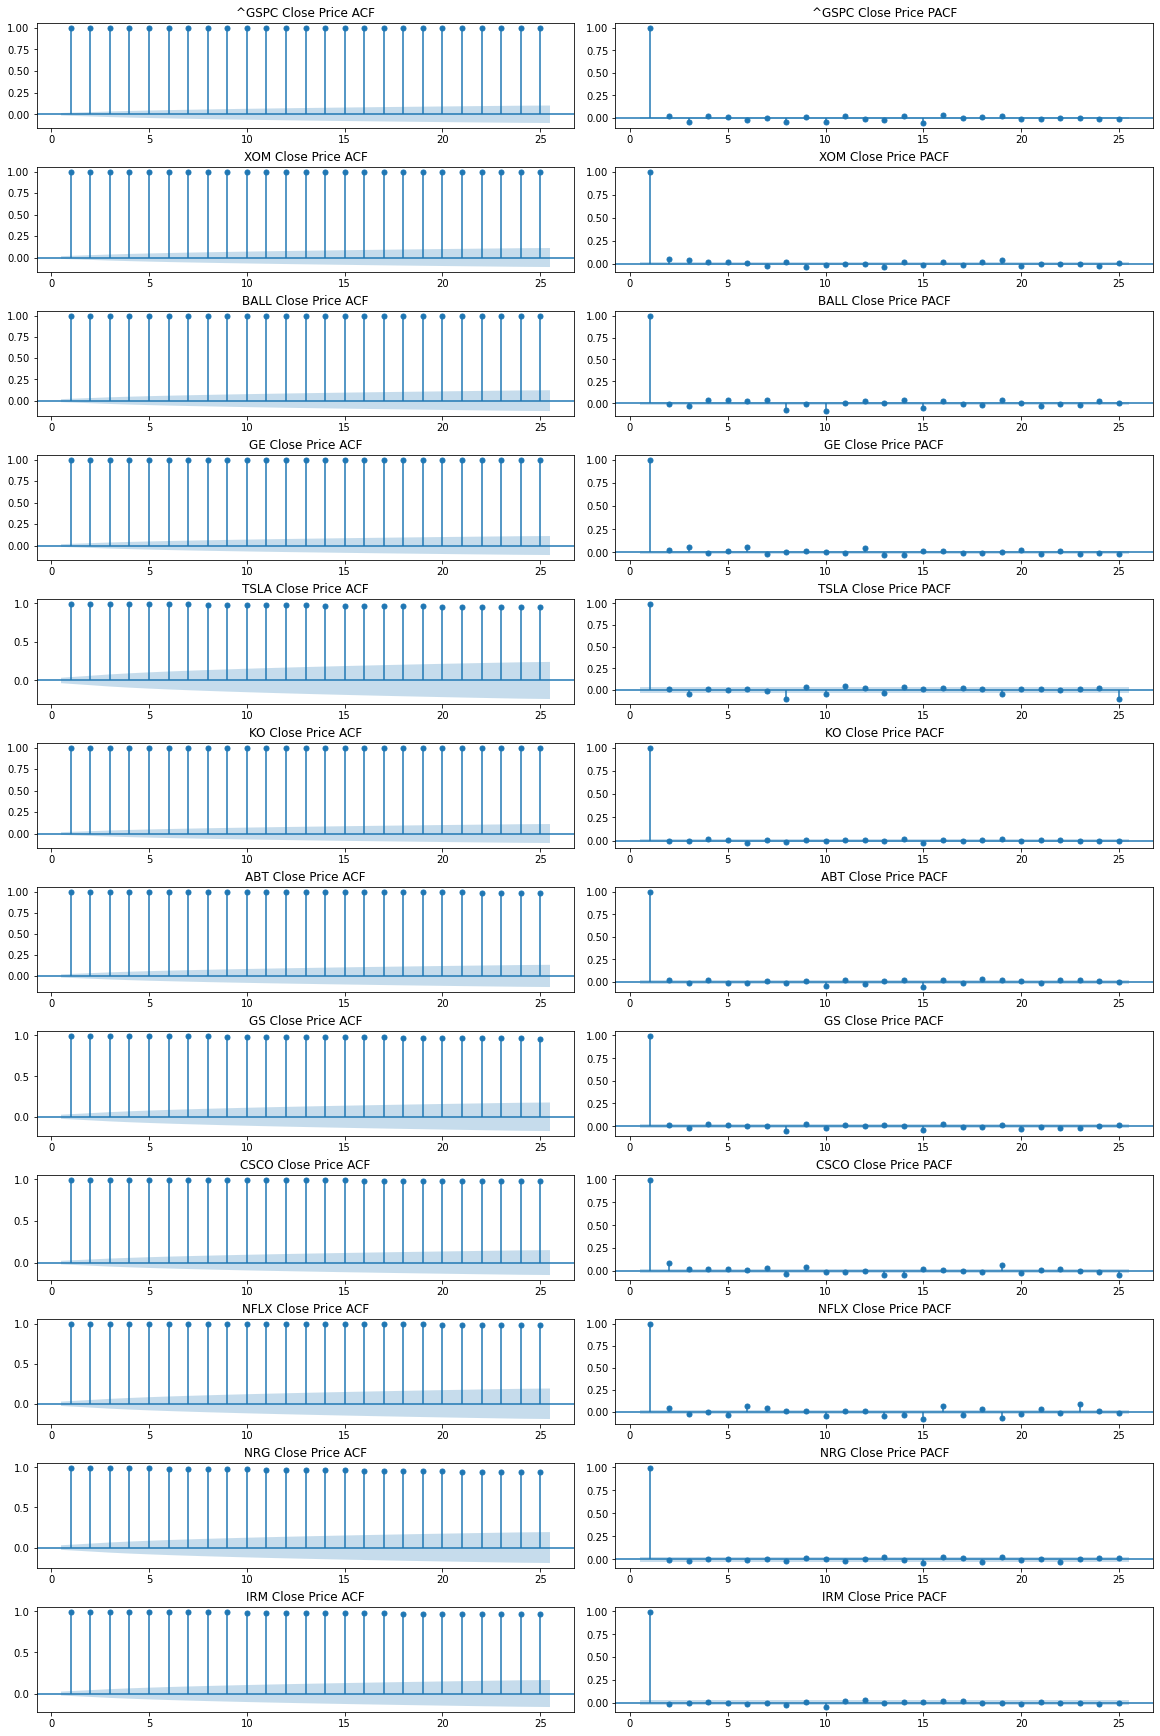

In [14]:
# Plotting ACF or PACF for closing prices

fig, axes = plt.subplots(12,2,figsize=(16,24), constrained_layout = True)

for iticker in range(len(tickers)):
    df_stock_prices_select = df_stock_prices[tickers[iticker]]['Close'].dropna() 
    # Create subplots
    fig = plot_acf(df_stock_prices_select, lags=25, zero=False, ax=axes[iticker,0], title=tickers[iticker] + ' Close Price ACF')    
    fig = plot_pacf(df_stock_prices_select, lags=25, zero=False, ax=axes[iticker,1], title=tickers[iticker] + ' Close Price PACF')    

plt.show()

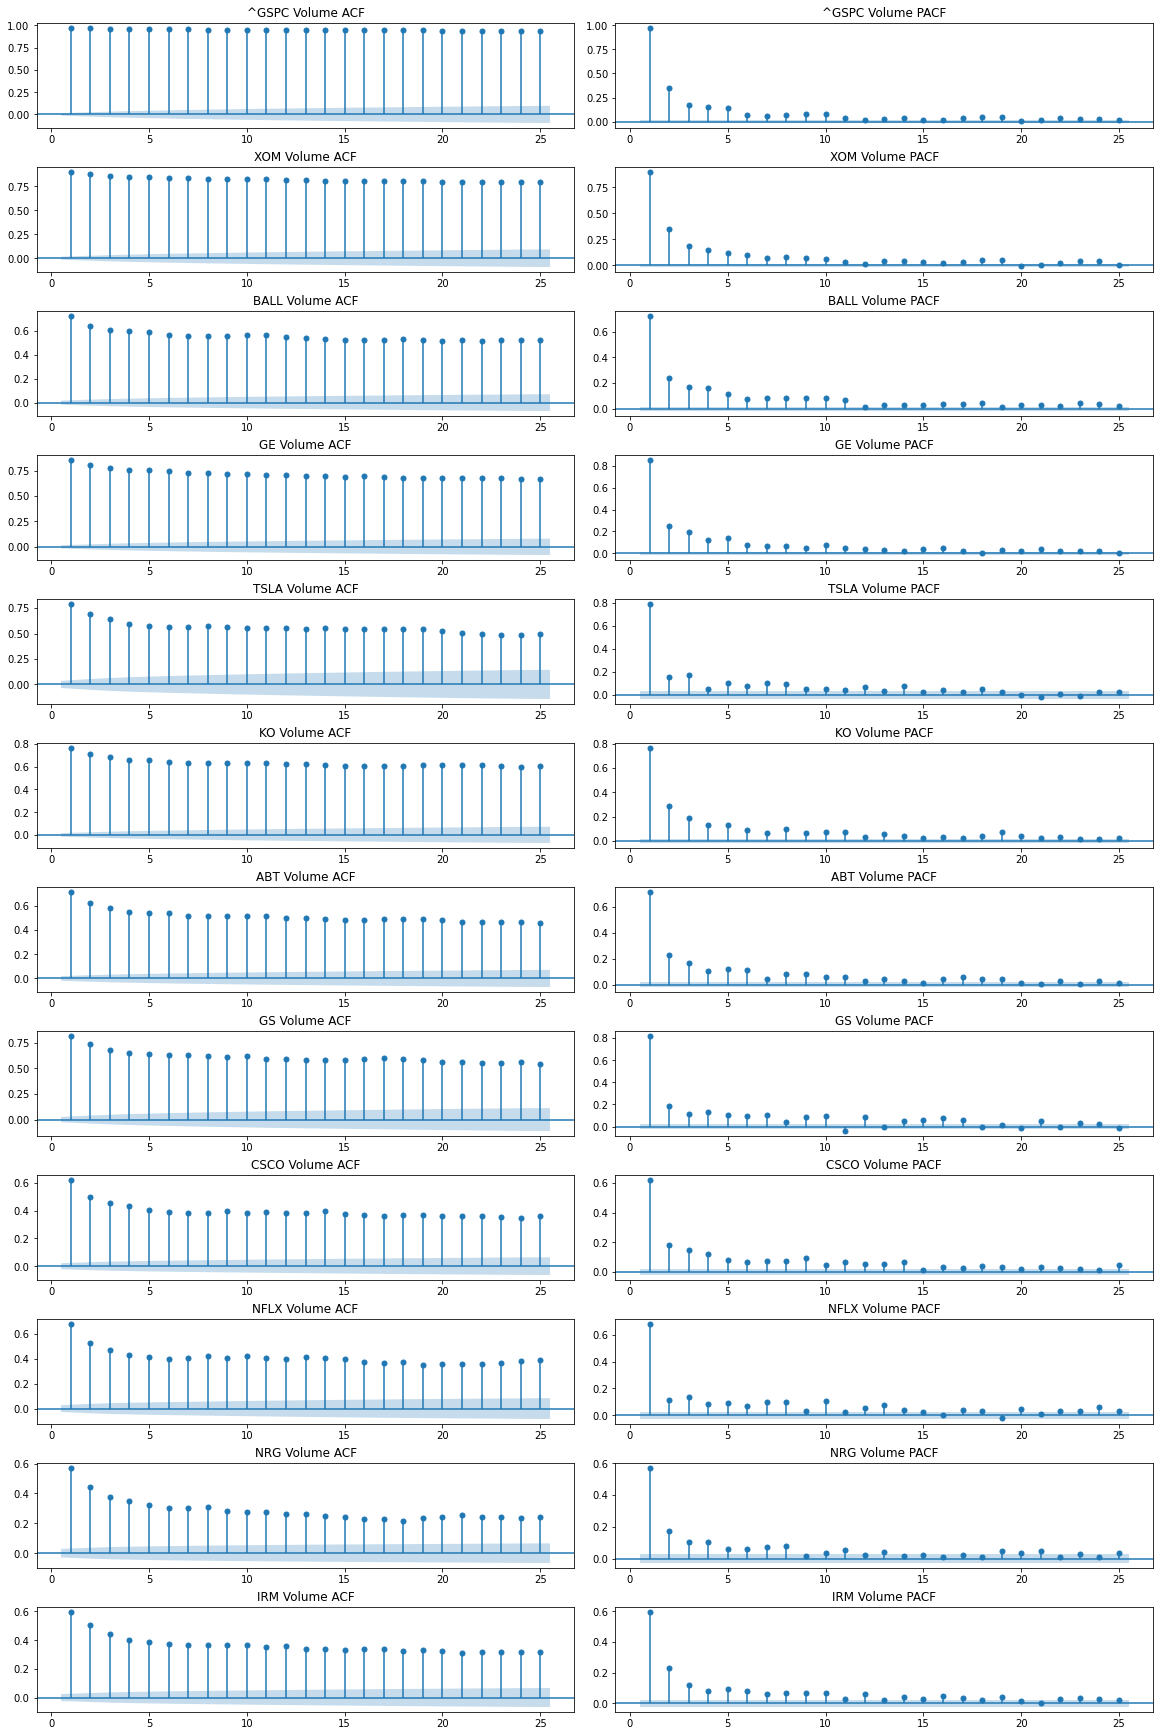

In [15]:
# Plotting ACF or PACF for trading volume
fig, axes = plt.subplots(12,2,figsize=(16,24), constrained_layout = True)

for iticker in range(len(tickers)):
    df_stock_prices_select = df_stock_prices[tickers[iticker]]['Volume'].dropna() 
    # Create subplots
    fig = plot_acf(df_stock_prices_select, lags=25, zero=False, ax=axes[iticker,0], title=tickers[iticker] + ' Volume ACF')    
    fig = plot_pacf(df_stock_prices_select, lags=25, zero=False, ax=axes[iticker,1], title=tickers[iticker] + ' Volume PACF')    

plt.show()

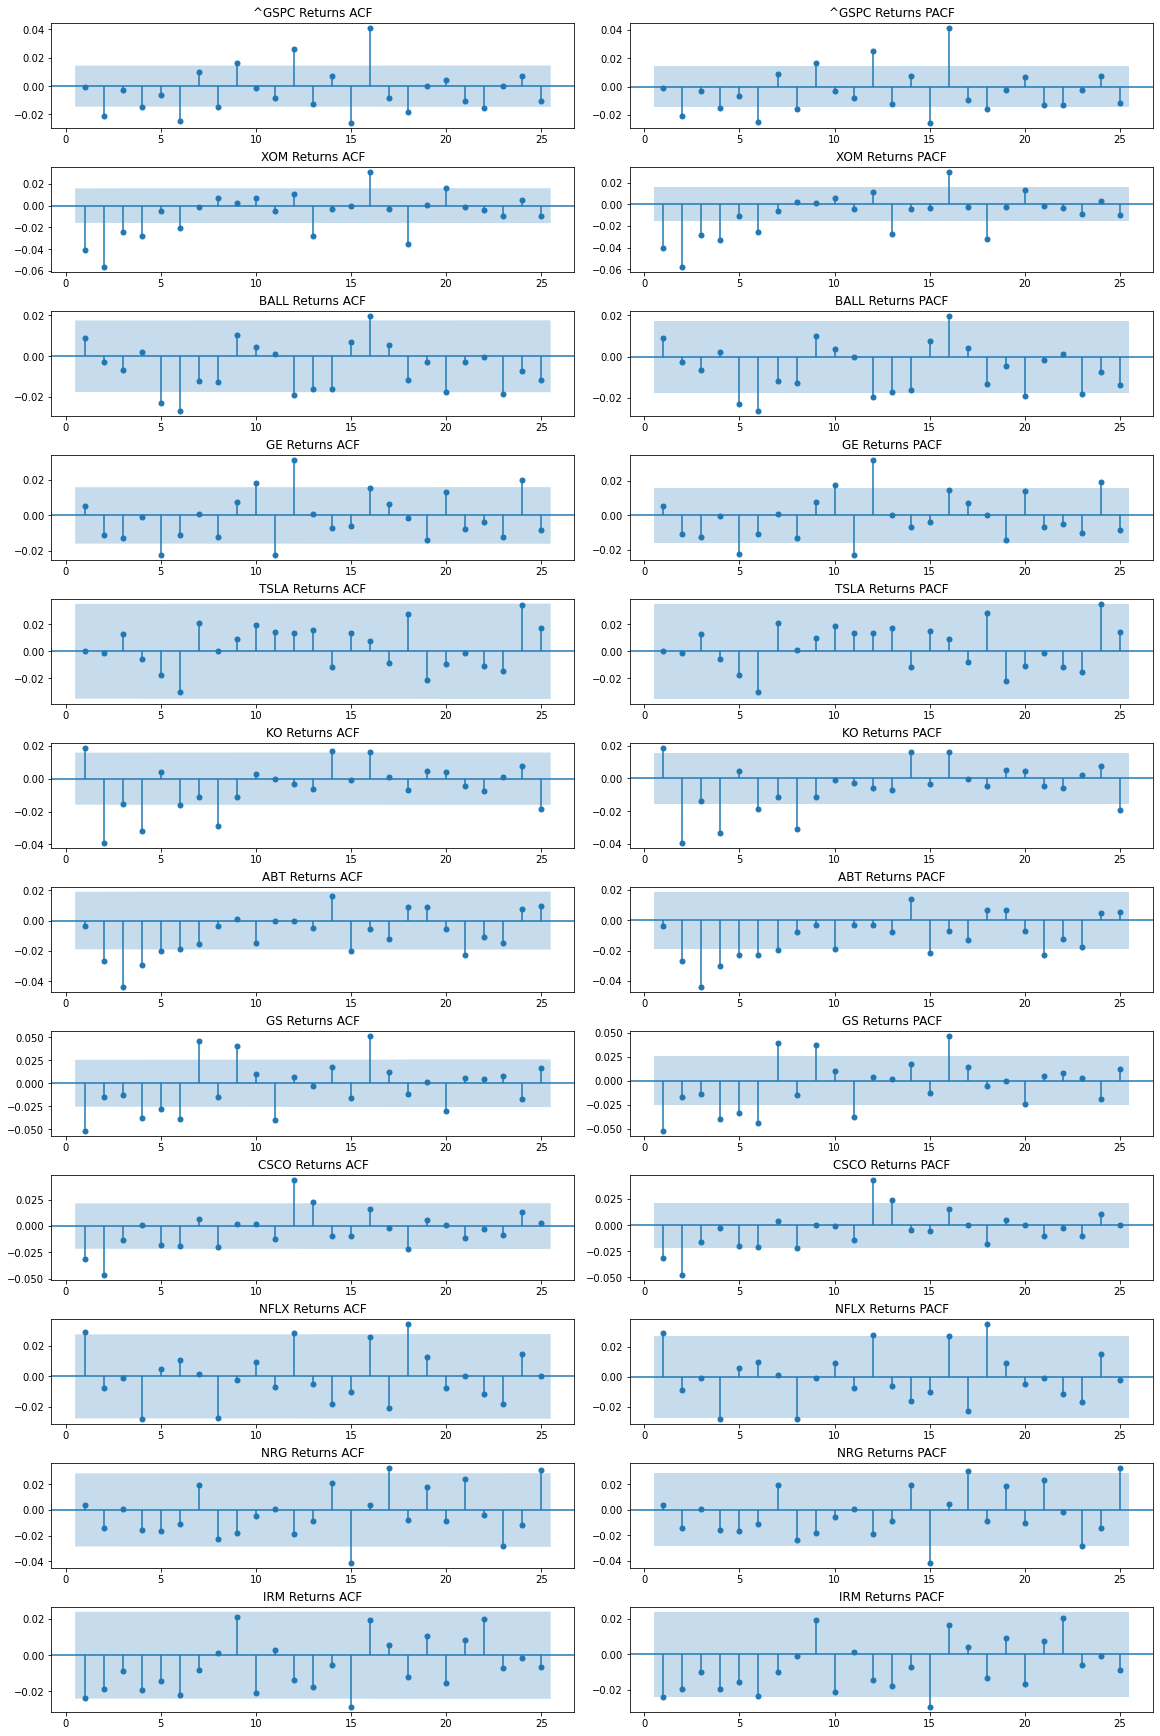

In [18]:
# Plotting ACF or PACF for stock returns
fig, axes = plt.subplots(12,2,figsize=(16,24), constrained_layout = True)

for iticker in range(len(tickers)):
    df_stock_returns_select = df_stock_returns[tickers[iticker]]['Close'].dropna() 
    # Create subplots
    fig = plot_acf(df_stock_returns_select, lags=25, zero=False, ax=axes[iticker,0], title=tickers[iticker] + ' Returns ACF')    
    fig = plot_pacf(df_stock_returns_select, lags=25, zero=False, ax=axes[iticker,1], title=tickers[iticker] + ' Returns PACF')    

plt.show()

#### Augmented Dickey Fuller (ADF) Stationarity Test

In [19]:
num_nonstationary = 0

for iticker in range(len(tickers)):
    iresult_adtest = adfuller(df_stock_returns[tickers[iticker]]['Close'].dropna())
    print(tickers[iticker])
    print('ADF Statistic: %f' % iresult_adtest[0])
    print('pvalue: %f' % iresult_adtest[1])
    print('Critical values:')
    for ikey, ivalue in iresult_adtest[4].items():
        print('\t%s: %.3f' % (ikey, ivalue))
    print('-'*100)
    
    if iresult_adtest[1] > 0.05:
        num_nonstationary += 1

if num_nonstationary == 0:
  print("All stock returns are stationary.")

^GSPC
ADF Statistic: -23.776393
pvalue: 0.000000
Critical values:
	1%: -3.431
	5%: -2.862
	10%: -2.567
----------------------------------------------------------------------------------------------------
XOM
ADF Statistic: -30.753055
pvalue: 0.000000
Critical values:
	1%: -3.431
	5%: -2.862
	10%: -2.567
----------------------------------------------------------------------------------------------------
BALL
ADF Statistic: -22.655108
pvalue: 0.000000
Critical values:
	1%: -3.431
	5%: -2.862
	10%: -2.567
----------------------------------------------------------------------------------------------------
GE
ADF Statistic: -19.342471
pvalue: 0.000000
Critical values:
	1%: -3.431
	5%: -2.862
	10%: -2.567
----------------------------------------------------------------------------------------------------
TSLA
ADF Statistic: -55.529904
pvalue: 0.000000
Critical values:
	1%: -3.432
	5%: -2.862
	10%: -2.567
----------------------------------------------------------------------------------------

#### Kwiatkowski–Phillips–Schmidt–Shin (KPSS) Stationarity Test

In [20]:
num_nonstationary = 0

for iticker in range(len(tickers)):
    iresult_kpsstest = kpss(df_stock_returns[tickers[iticker]]['Close'].dropna())
    print(tickers[iticker])
    print('KPSS Statistic: %f' % iresult_kpsstest[0])
    print('pvalue: %f' % iresult_kpsstest[1])
    print('Critical values:')
    for ikey, ivalue in iresult_kpsstest[3].items():
        print('\t%s: %.3f' % (ikey, ivalue))
    print('-'*100)
    
    if iresult_kpsstest[1] < 0.05:
        num_nonstationary += 1

if num_nonstationary == 0:
  print("All stock returns are stationary.")

^GSPC
KPSS Statistic: 0.057571
pvalue: 0.100000
Critical values:
	10%: 0.347
	5%: 0.463
	2.5%: 0.574
	1%: 0.739
----------------------------------------------------------------------------------------------------
XOM
KPSS Statistic: 0.083093
pvalue: 0.100000
Critical values:
	10%: 0.347
	5%: 0.463
	2.5%: 0.574
	1%: 0.739
----------------------------------------------------------------------------------------------------
BALL
KPSS Statistic: 0.046649
pvalue: 0.100000
Critical values:
	10%: 0.347
	5%: 0.463
	2.5%: 0.574
	1%: 0.739
----------------------------------------------------------------------------------------------------
GE
KPSS Statistic: 0.225728
pvalue: 0.100000
Critical values:
	10%: 0.347
	5%: 0.463
	2.5%: 0.574
	1%: 0.739
----------------------------------------------------------------------------------------------------
TSLA
KPSS Statistic: 0.118676
pvalue: 0.100000
Critical values:
	10%: 0.347
	5%: 0.463
	2.5%: 0.574
	1%: 0.739
-------------------------------------------

c:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:1875: FutureWarning: The behavior of using nlags=None will change in release 0.13.Currently nlags=None is the same as nlags="legacy", and so a sample-size lag length is used. After the next release, the default will change to be the same as nlags="auto" which uses an automatic lag length selection method. To silence this warning, either use "auto" or "legacy"
  warnings.warn(msg, FutureWarning)
c:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:1910: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(
c:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:1910: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(
c:\Pro

#### Missing Values and Deleting duplicate data

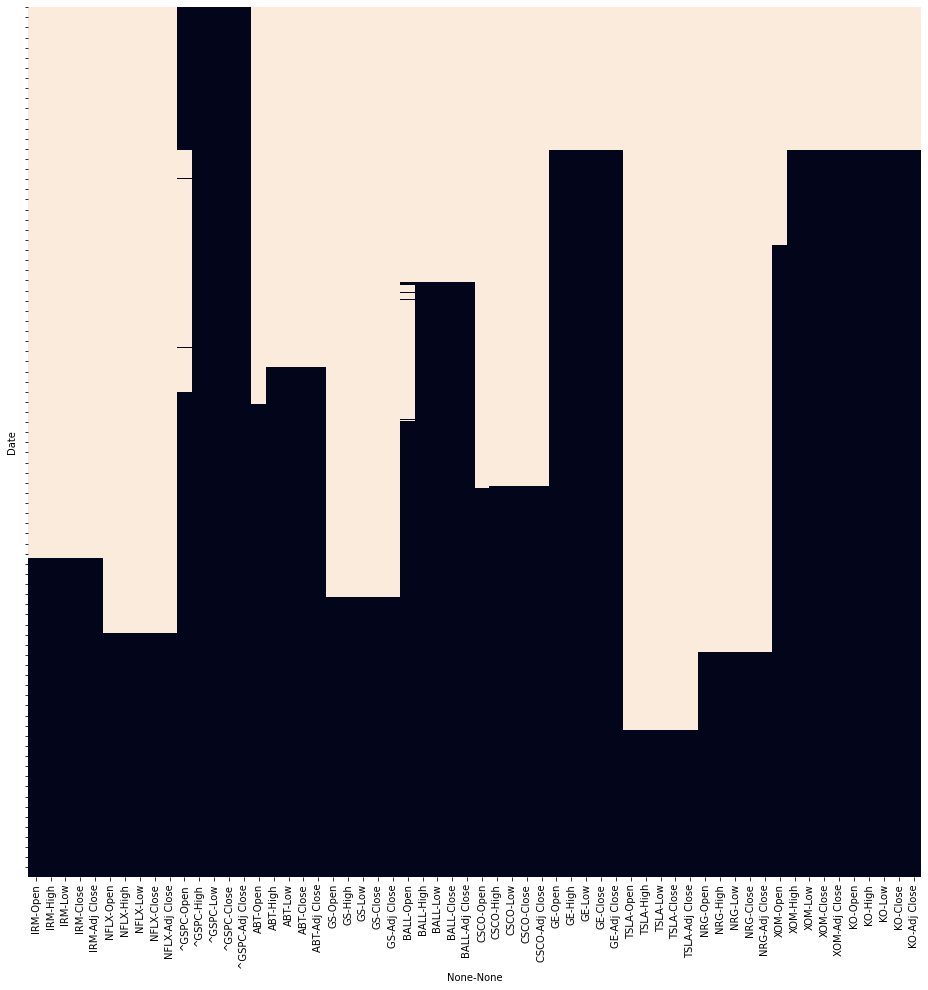

In [21]:
# Visualize the missing values
plt.figure(figsize=(16, 16))
heatmap_returns = sns.heatmap(df_stock_returns.isnull(), cbar=False)
heatmap_returns.set_yticklabels([])
plt.show()

In [22]:
# Creating a data frame consisting of stock returns
fields_prices    = ['Open', 'High', 'Low', 'Close', 'Adj Close']
fields_all       = df_stock_prices.columns.get_level_values(1).drop_duplicates().tolist()
fields_drop      = list(set(fields_all) - set(fields_prices))
print(fields_all)
print(fields_drop)
df_stock_prices = df_stock_prices.drop(fields_drop, level=1, axis=1)
display(df_stock_prices)

['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume', 'Close SMA60', 'Close SMA250', 'Volume SMA60', 'Volume SMA250']
['Close SMA60', 'Close SMA250', 'Volume SMA60', 'Volume', 'Volume SMA250']


IRM                                                    NFLX  \
                 Open       High        Low      Close  Adj Close        Open   
Date                                                                            
1950-01-03        NaN        NaN        NaN        NaN        NaN         NaN   
1950-01-04        NaN        NaN        NaN        NaN        NaN         NaN   
1950-01-05        NaN        NaN        NaN        NaN        NaN         NaN   
1950-01-06        NaN        NaN        NaN        NaN        NaN         NaN   
1950-01-09        NaN        NaN        NaN        NaN        NaN         NaN   
...               ...        ...        ...        ...        ...         ...   
2022-09-26  46.240002  46.299999  44.470001  44.730000  44.730000  225.600006   
2022-09-27  45.230000  45.410000  43.439999  43.590000  43.590000  228.630005   
2022-09-28  44.090000  45.220001  43.529999  44.910000  44.910000  229.690002   
2022-09-29  44.400002  44.430000  43.330002  43.810001  43.810001  241.610001   
2022-09-30  44.599998  44.860001  43.880001  43.970001  43.970001  237.000000   

                                                            ...        XOM  \
                  High         Low       Close   Adj Close  ...       Open   
Date                                                        ...              
1950-01-03         NaN         NaN         NaN         NaN  ...        NaN   
1950-01-04         NaN         NaN         NaN         NaN  ...        NaN   
1950-01-05         NaN         NaN         NaN         NaN  ...        NaN   
1950-01-06         NaN         NaN         NaN         NaN  ...        NaN   
1950-01-09         NaN         NaN         NaN         NaN  ...        NaN   
...                ...         ...         ...         ...  ...        ...   
2022-09-26  232.699997  223.009995  224.070007  224.070007  ...  84.900002   
2022-09-27  230.639999  220.720001  224.360001  224.360001  ...  85.610001   
2022-09-28  246.649994  227.380005  245.199997  245.199997  ...  86.120003   
2022-09-29  246.979996  235.679993  239.710007  239.710007  ...  88.180000   
2022-09-30  242.440002  233.259995  235.440002  235.440002  ...  88.169998   

                                                               KO             \
                 High        Low      Close  Adj Close       Open       High   
Date                                                                           
1950-01-03        NaN        NaN        NaN        NaN        NaN        NaN   
1950-01-04        NaN        NaN        NaN        NaN        NaN        NaN   
1950-01-05        NaN        NaN        NaN        NaN        NaN        NaN   
1950-01-06        NaN        NaN        NaN        NaN        NaN        NaN   
1950-01-09        NaN        NaN        NaN        NaN        NaN        NaN   
...               ...        ...        ...        ...        ...        ...   
2022-09-26  86.220001  83.889999  83.980003  83.980003  58.490002  58.570000   
2022-09-27  86.959999  84.809998  85.739998  85.739998  58.080002  58.369999   
2022-09-28  89.300003  85.919998  88.860001  88.860001  56.660000  57.250000   
2022-09-29  89.360001  87.129997  88.680000  88.680000  57.090000  57.290001   
2022-09-30  89.040001  87.309998  87.309998  87.309998  56.869999  57.130001   

                                             
                  Low      Close  Adj Close  
Date                                         
1950-01-03        NaN        NaN        NaN  
1950-01-04        NaN        NaN        NaN  
1950-01-05        NaN        NaN        NaN  
1950-01-06        NaN        NaN        NaN  
1950-01-09        NaN        NaN        NaN  
...               ...        ...        ...  
2022-09-26  57.689999  57.869999  57.869999  
2022-09-27  56.310001  56.380001  56.380001  
2022-09-28  55.910000  56.980000  56.980000  
2022-09-29  56.000000  56.570000  56.570000  
2022-09-30  56.000000  56.020000  56.020000  

[18306 rows x 60 columns

In [23]:
# Count duplicates in the stock prices data (we will remove derived indicators)
df_stock_prices_1lag = df_stock_prices.shift(1)
check_duplicates = (df_stock_prices_1lag == df_stock_prices)
check_duplicates = check_duplicates.drop(fields_drop, level=1, axis=1)
count_duplicates = check_duplicates.astype(int).sum()

print('check_duplicates')
print(check_duplicates)
print('-'*100)
print('count_duplicates')
print(count_duplicates)
print('-'*100)

check_duplicates
              IRM                                  NFLX                       \
             Open   High    Low  Close Adj Close   Open   High    Low  Close   
Date                                                                           
1950-01-03  False  False  False  False     False  False  False  False  False   
1950-01-04  False  False  False  False     False  False  False  False  False   
1950-01-05  False  False  False  False     False  False  False  False  False   
1950-01-06  False  False  False  False     False  False  False  False  False   
1950-01-09  False  False  False  False     False  False  False  False  False   
...           ...    ...    ...    ...       ...    ...    ...    ...    ...   
2022-09-26  False  False  False  False     False  False  False  False  False   
2022-09-27  False  False  False  False     False  False  False  False  False   
2022-09-28  False  False  False  False     False  False  False  False  False   
2022-09-29  False  Fals

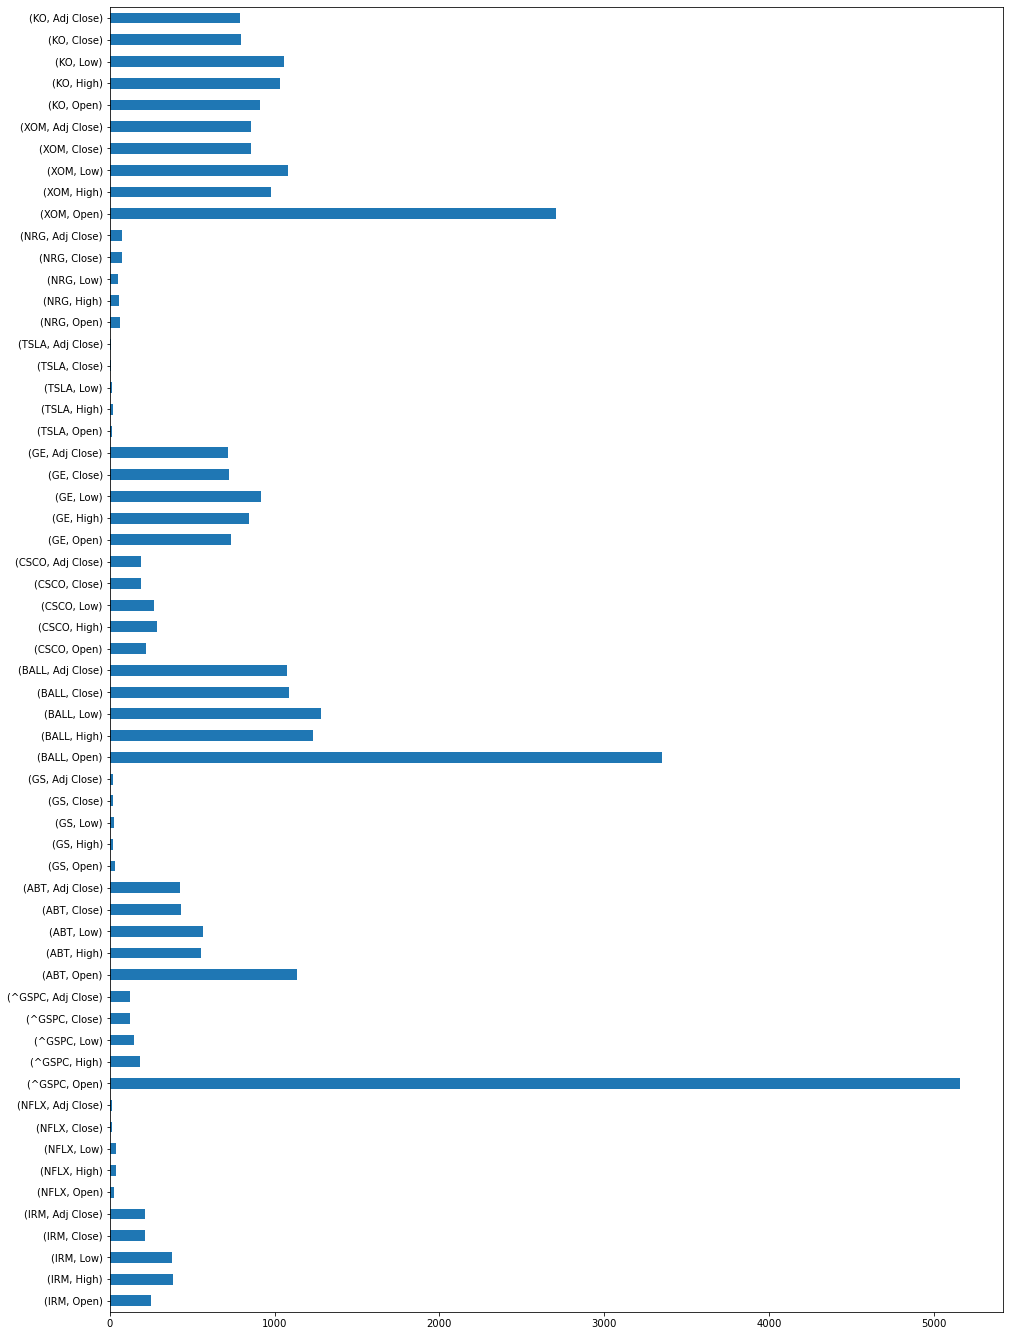

In [24]:
# Create a bar chart to visualize count_duplicates
plt.figure(figsize=(16, 24))
count_duplicates.plot.barh()
plt.show()

In [25]:
# Transform the duplicates indicator (should consist of NaNs, zeros, and ones for better visualization)
check_duplicates = check_duplicates.astype(int)
check_duplicates = check_duplicates.where(df_stock_prices.drop(fields_drop, level=1, axis=1).isna().values !=True, other=float('NaN'))

print('check_duplicates')
print(check_duplicates)

check_duplicates
            IRM                           NFLX                            ...  \
           Open High  Low Close Adj Close Open High  Low Close Adj Close  ...   
Date                                                                      ...   
1950-01-03  NaN  NaN  NaN   NaN       NaN  NaN  NaN  NaN   NaN       NaN  ...   
1950-01-04  NaN  NaN  NaN   NaN       NaN  NaN  NaN  NaN   NaN       NaN  ...   
1950-01-05  NaN  NaN  NaN   NaN       NaN  NaN  NaN  NaN   NaN       NaN  ...   
1950-01-06  NaN  NaN  NaN   NaN       NaN  NaN  NaN  NaN   NaN       NaN  ...   
1950-01-09  NaN  NaN  NaN   NaN       NaN  NaN  NaN  NaN   NaN       NaN  ...   
...         ...  ...  ...   ...       ...  ...  ...  ...   ...       ...  ...   
2022-09-26  0.0  0.0  0.0   0.0       0.0  0.0  0.0  0.0   0.0       0.0  ...   
2022-09-27  0.0  0.0  0.0   0.0       0.0  0.0  0.0  0.0   0.0       0.0  ...   
2022-09-28  0.0  0.0  0.0   0.0       0.0  0.0  0.0  0.0   0.0       0.0  ...   
2022-09-29 

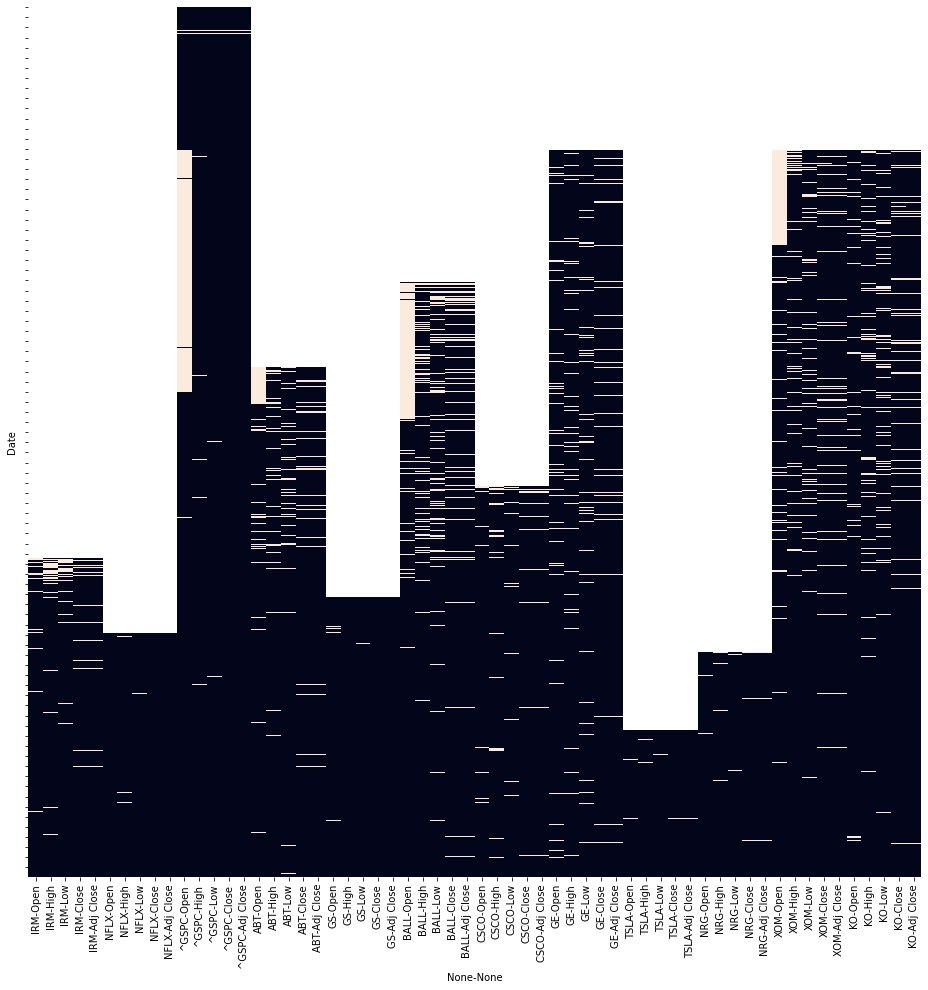

In [26]:
# Visualize the duplicates
plt.figure(figsize=(16, 16))
heatmap_duplicates = sns.heatmap(check_duplicates, cbar=False)
heatmap_duplicates.set_yticklabels([])
plt.show()

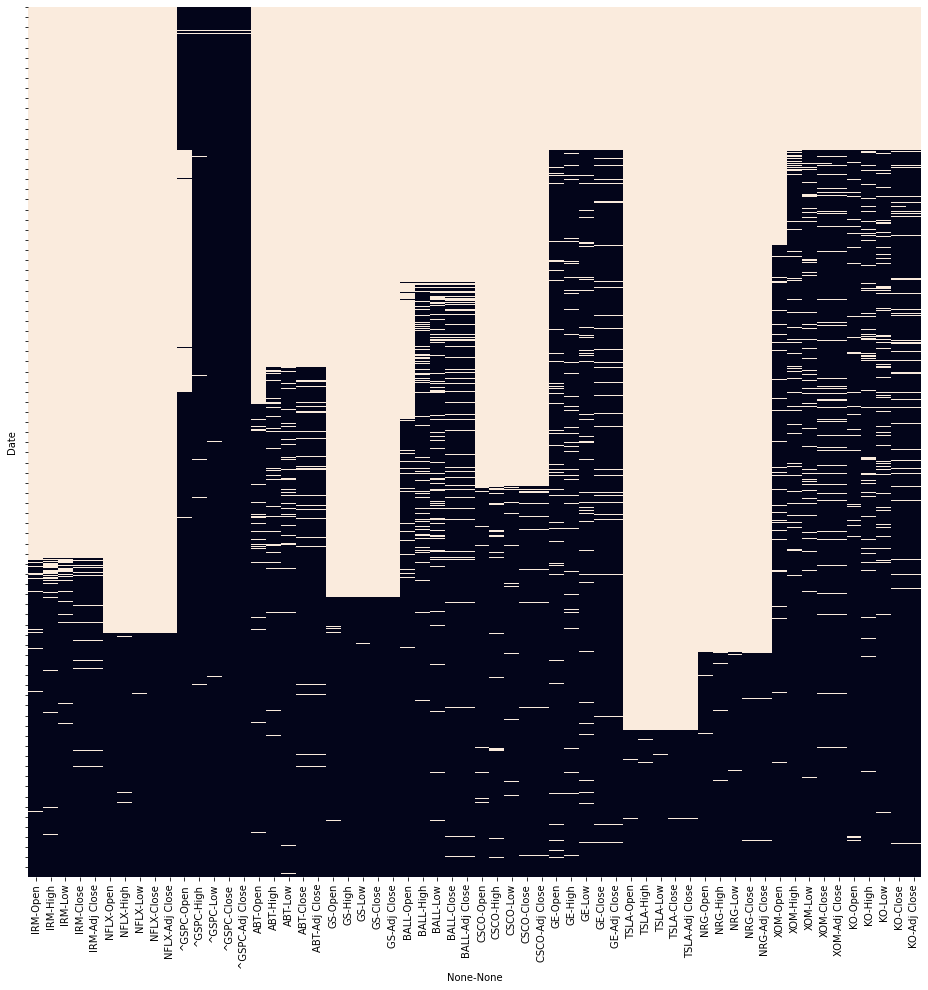

In [27]:
# Validation using stock returns instead of prices
df_stock_returns_doubleval = df_stock_returns.where((df_stock_returns != 'NaN') & ((df_stock_returns < -0.000001) | (df_stock_returns > 0.000001)))
plt.figure(figsize=(16, 16))
heatmap_returns_doubleval = sns.heatmap(df_stock_returns_doubleval.isnull(), cbar=False)
heatmap_returns_doubleval.set_yticklabels([])
plt.show()

In [28]:
# Replacement by combining the methods mask and fillna: First step 
df_stock_returns_final2 = df_stock_returns.mask(df_stock_returns==0).fillna(df_stock_returns.mean())
print(df_stock_returns_final2)

                 IRM                                              NFLX  \
                Open      High       Low     Close Adj Close      Open   
Date                                                                     
1950-01-03  0.000613  0.000582  0.000585  0.000609  0.000728  0.001733   
1950-01-04  0.000613  0.000582  0.000585  0.000609  0.000728  0.001733   
1950-01-05  0.000613  0.000582  0.000585  0.000609  0.000728  0.001733   
1950-01-06  0.000613  0.000582  0.000585  0.000609  0.000728  0.001733   
1950-01-09  0.000613  0.000582  0.000585  0.000609  0.000728  0.001733   
...              ...       ...       ...       ...       ...       ...   
2022-09-26 -0.021997 -0.025468 -0.036403 -0.040129 -0.040129 -0.040572   
2022-09-27 -0.021843 -0.019222 -0.023162 -0.025486 -0.025486  0.013431   
2022-09-28 -0.025204 -0.004184  0.002072  0.030282  0.030282  0.004636   
2022-09-29  0.007031 -0.017470 -0.004594 -0.024493 -0.024493  0.051896   
2022-09-30  0.004504  0.009678  0.0126

In [29]:
# Replacement by combining the methods mask and fillna: Second step 
df_stock_returns_final2 = df_stock_returns_final2.where(df_stock_prices.drop(fields_drop, level=1, axis=1).isna().values==False, other=float('NaN'))
print(df_stock_returns_final2)

                 IRM                                              NFLX  \
                Open      High       Low     Close Adj Close      Open   
Date                                                                     
1950-01-03       NaN       NaN       NaN       NaN       NaN       NaN   
1950-01-04       NaN       NaN       NaN       NaN       NaN       NaN   
1950-01-05       NaN       NaN       NaN       NaN       NaN       NaN   
1950-01-06       NaN       NaN       NaN       NaN       NaN       NaN   
1950-01-09       NaN       NaN       NaN       NaN       NaN       NaN   
...              ...       ...       ...       ...       ...       ...   
2022-09-26 -0.021997 -0.025468 -0.036403 -0.040129 -0.040129 -0.040572   
2022-09-27 -0.021843 -0.019222 -0.023162 -0.025486 -0.025486  0.013431   
2022-09-28 -0.025204 -0.004184  0.002072  0.030282  0.030282  0.004636   
2022-09-29  0.007031 -0.017470 -0.004594 -0.024493 -0.024493  0.051896   
2022-09-30  0.004504  0.009678  0.0126

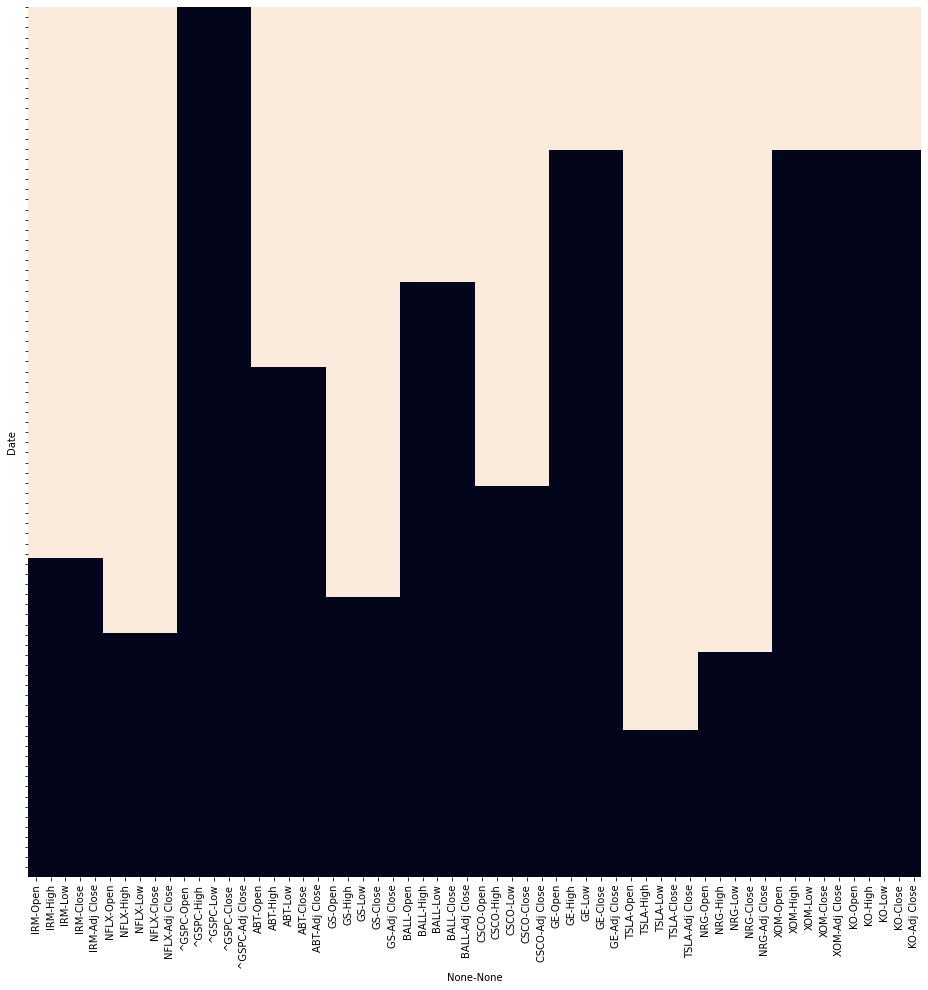

In [30]:
# Validation step (visalization)
df_stock_returns_doubleval2 = df_stock_returns_final2.where((df_stock_returns_final2 != float('NaN')) & ((df_stock_returns_final2 < -0.000001) | (df_stock_returns_final2 > 0.000001)))
plt.figure(figsize=(16, 16))
heatmap_returns_doubleval = sns.heatmap(df_stock_returns_doubleval2.isnull(), cbar=False)
heatmap_returns_doubleval.set_yticklabels([])
plt.show()

Plotting Outliers

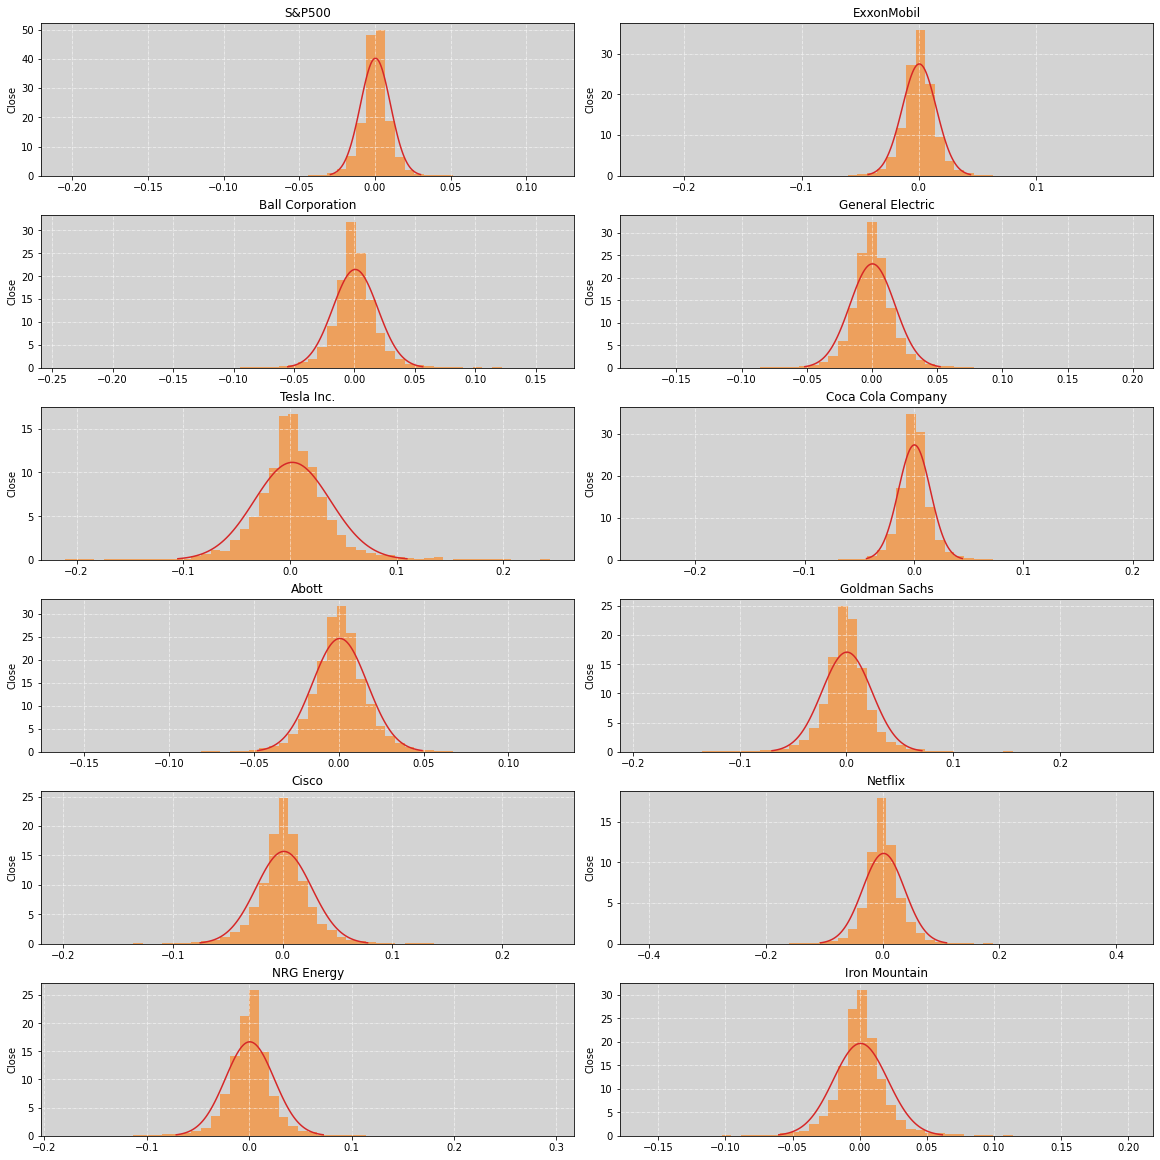

In [31]:
# Plotting returns histograms (for returns based on closing prices)
plt.figure(figsize=(16, 16), constrained_layout = True)

for iticker in range(len(tickers)):
    # Prepare inputs for normal distribution plot overlay
    mean_val  = df_stock_returns_final2[tickers[iticker]]['Close'].mean()
    std_val   = df_stock_returns_final2[tickers[iticker]]['Close'].std()
    min_val   = df_stock_returns_final2[tickers[iticker]]['Close'].min()
    max_val   = df_stock_returns_final2[tickers[iticker]]['Close'].max()
    x_norm    = np.linspace(mean_val-3*std_val, mean_val+3*std_val, 100)  # alternative: np.linspace(min_val, max_val, 100)
    #x_norm    = np.linspace(min_val, max_val, 100)
    y_norm  = scipy.stats.norm.pdf(x_norm,mean_val,std_val)
    
    # Create subplots
    plt.subplot(6, 2, iticker+1)    
    df_stock_returns_final2[tickers[iticker]]['Close'].hist(bins=50, alpha=0.6, density=True, color='tab:orange')
    plt.plot(x_norm, y_norm, color='tab:red', linewidth=1.5)
    
    # Labels and graphics
    plt.xlabel(None)
    plt.ylabel('Close')
    plt.title(names[iticker])
    plt.grid(color='white', linestyle='-.', linewidth=0.5)
    ax = plt.gca()
    ax.set_facecolor('lightgrey')

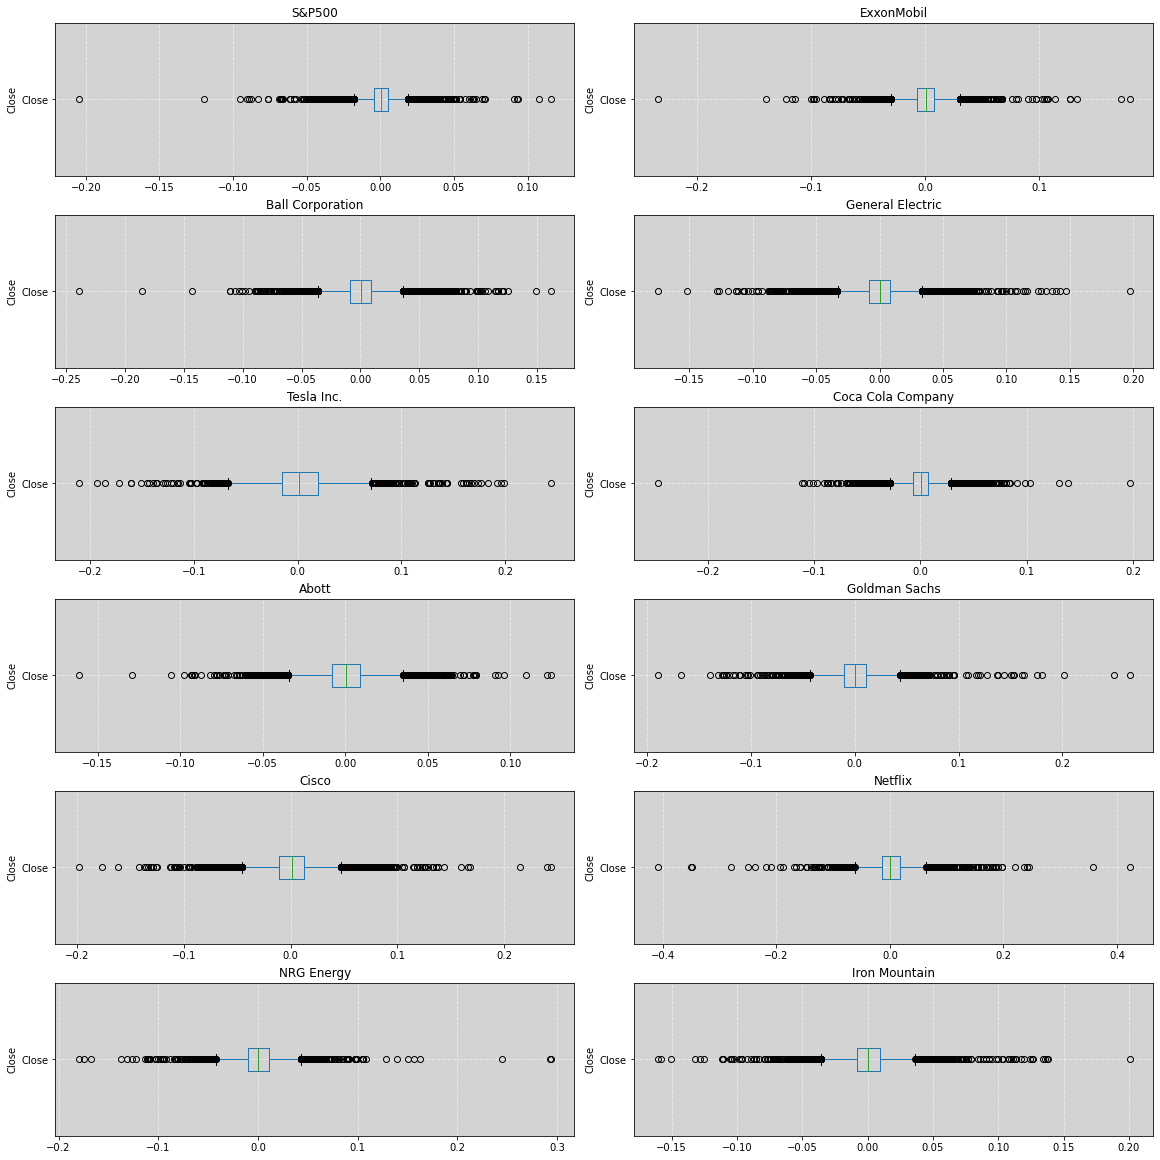

In [32]:
# Plotting returns boxplots (for returns based on closing prices)
plt.figure(figsize=(16, 16), constrained_layout = True)

for iticker in range(len(tickers)):
    # Create subplots
    plt.subplot(6, 2, iticker+1)
    idf = df_stock_returns_final2[tickers[iticker]]
    idf.boxplot('Close',vert=False)
    # Labels and graphics
    plt.xlabel(None)
    plt.ylabel('Close')
    plt.title(names[iticker])
    plt.grid(color='white', linestyle='-.', linewidth=0.5)
    ax = plt.gca()
    ax.set_facecolor('lightgrey')

In [33]:
# Compute skewness and kurtosis
print('Skewness:')
print(df_stock_returns_final2.skew())
print('-'*100)
print('Kurtosis:')
print(df_stock_returns_final2.kurt())
print('-'*100)

Skewness:
IRM    Open         0.390754
       High         1.357776
       Low         -0.280536
       Close        0.202671
       Adj Close    0.233246
NFLX   Open         0.503901
       High         0.685171
       Low         -0.399490
       Close        0.097468
       Adj Close    0.097468
^GSPC  Open              NaN
       High        -0.306092
       Low         -0.704789
       Close       -0.650173
       Adj Close   -0.650173
ABT    Open              NaN
       High         0.228738
       Low         -0.135554
       Close       -0.102846
       Adj Close   -0.102738
GS     Open         0.674940
       High         1.025059
       Low          0.793934
       Close        0.719670
       Adj Close    0.716628
BALL   Open              NaN
       High         0.564661
       Low         -0.263836
       Close        0.122172
       Adj Close    0.133838
CSCO   Open              NaN
       High         0.165955
       Low          0.328659
       Close        0.258677
    

In [34]:
# Create data frame with clipped stock returns
df_stock_returns_final_clip = df_stock_returns_final2.copy()
clip_returns = df_stock_returns_final2.clip(lower=df_stock_returns_final2.quantile(0.01), upper=df_stock_returns_final2.quantile(0.99), axis=1)
df_stock_returns_final_clip.iloc[:] = clip_returns 
display(df_stock_returns_final_clip)

c:\ProgramData\Anaconda3\lib\site-packages\numpy\lib\function_base.py:3961: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)


IRM                                              NFLX  \
                Open      High       Low     Close Adj Close      Open   
Date                                                                     
1950-01-03       NaN       NaN       NaN       NaN       NaN       NaN   
1950-01-04       NaN       NaN       NaN       NaN       NaN       NaN   
1950-01-05       NaN       NaN       NaN       NaN       NaN       NaN   
1950-01-06       NaN       NaN       NaN       NaN       NaN       NaN   
1950-01-09       NaN       NaN       NaN       NaN       NaN       NaN   
...              ...       ...       ...       ...       ...       ...   
2022-09-26 -0.021997 -0.025468 -0.036403 -0.040129 -0.040129 -0.040572   
2022-09-27 -0.021843 -0.019222 -0.023162 -0.025486 -0.025486  0.013431   
2022-09-28 -0.025204 -0.004184  0.002072  0.030282  0.030282  0.004636   
2022-09-29  0.007031 -0.017470 -0.004594 -0.024493 -0.024493  0.051896   
2022-09-30  0.004504  0.009678  0.012693  0.003652  0.003652 -0.019080   

                                                    ...       XOM            \
                High       Low     Close Adj Close  ...      Open      High   
Date                                                ...                       
1950-01-03       NaN       NaN       NaN       NaN  ...       NaN       NaN   
1950-01-04       NaN       NaN       NaN       NaN  ...       NaN       NaN   
1950-01-05       NaN       NaN       NaN       NaN  ...       NaN       NaN   
1950-01-06       NaN       NaN       NaN       NaN  ...       NaN       NaN   
1950-01-09       NaN       NaN       NaN       NaN  ...       NaN       NaN   
...              ...       ...       ...       ...  ...       ...       ...   
2022-09-26 -0.015860  0.007135 -0.010335 -0.010335  ... -0.029714 -0.014629   
2022-09-27 -0.008853 -0.010269  0.001294  0.001294  ...  0.008363  0.008583   
2022-09-28  0.069416  0.030174  0.092886  0.092886  ...  0.005957  0.026909   
2022-09-29  0.001338  0.036503 -0.022390 -0.022390  ...  0.023920  0.000672   
2022-09-30 -0.018382 -0.010268 -0.017813 -0.017813  ... -0.000113 -0.003581   

                                                KO                      \
                 Low     Close Adj Close      Open      High       Low   
Date                                                                     
1950-01-03       NaN       NaN       NaN       NaN       NaN       NaN   
1950-01-04       NaN       NaN       NaN       NaN       NaN       NaN   
1950-01-05       NaN       NaN       NaN       NaN       NaN       NaN   
1950-01-06       NaN       NaN       NaN       NaN       NaN       NaN   
1950-01-09       NaN       NaN       NaN       NaN       NaN       NaN   
...              ...       ...       ...       ...       ...       ...   
2022-09-26 -0.011314 -0.020641 -0.020641 -0.007971 -0.008968 -0.005345   
2022-09-27  0.010967  0.020957  0.020957 -0.007010 -0.003415 -0.023921   
2022-09-28  0.013088  0.036389  0.036389 -0.024449 -0.019188 -0.007104   
2022-09-29  0.014083 -0.002026 -0.002026  0.007589  0.000699  0.001610   
2022-09-30  0.002066 -0.015449 -0.015449 -0.003854 -0.002793  0.000449   

                                
               Close Adj Close  
Date                            
1950-01-03       NaN       NaN  
1950-01-04       NaN       NaN  
1950-01-05       NaN       NaN  
1950-01-06       NaN       NaN  
1950-01-09       NaN       NaN  
...              ...       ...  
2022-09-26 -0.012457 -0.012457  
2022-09-27 -0.025747 -0.025747  
2022-09-28  0.010642  0.010642  
2022-09-29 -0.007196 -0.007196  
2022-09-30 -0.009722 -0.009722  

[18306 rows x 60 columns]

In [35]:
# Sanity check
print('Input returns minimum:')
print(df_stock_returns_final2.min())
print('-'*100)
print('Trimmed returns minimum:')
print(df_stock_returns_final_clip.min())
print('-'*100)
print('Input returns maximum:')
print(df_stock_returns_final2.max())
print('-'*100)
print('Trimmed returns maximum:')
print(df_stock_returns_final_clip.max())
print('-'*100)

Input returns minimum:
IRM    Open        -0.172434
       High        -0.147050
       Low         -0.182060
       Close       -0.160714
       Adj Close   -0.160714
NFLX   Open        -0.424885
       High        -0.350847
       Low         -0.414118
       Close       -0.409065
       Adj Close   -0.409065
^GSPC  Open        -1.000000
       High        -0.131164
       Low         -0.201371
       Close       -0.204669
       Adj Close   -0.204669
ABT    Open        -0.149020
       High        -0.124031
       Low         -0.192118
       Close       -0.161375
       Adj Close   -0.161375
GS     Open        -0.268705
       High        -0.164285
       Low         -0.260000
       Close       -0.189596
       Adj Close   -0.189596
BALL   Open        -1.000000
       High        -0.137931
       Low         -0.273333
       Close       -0.239203
       Adj Close   -0.239203
CSCO   Open        -0.193878
       High        -0.190954
       Low         -0.207208
       Close       -

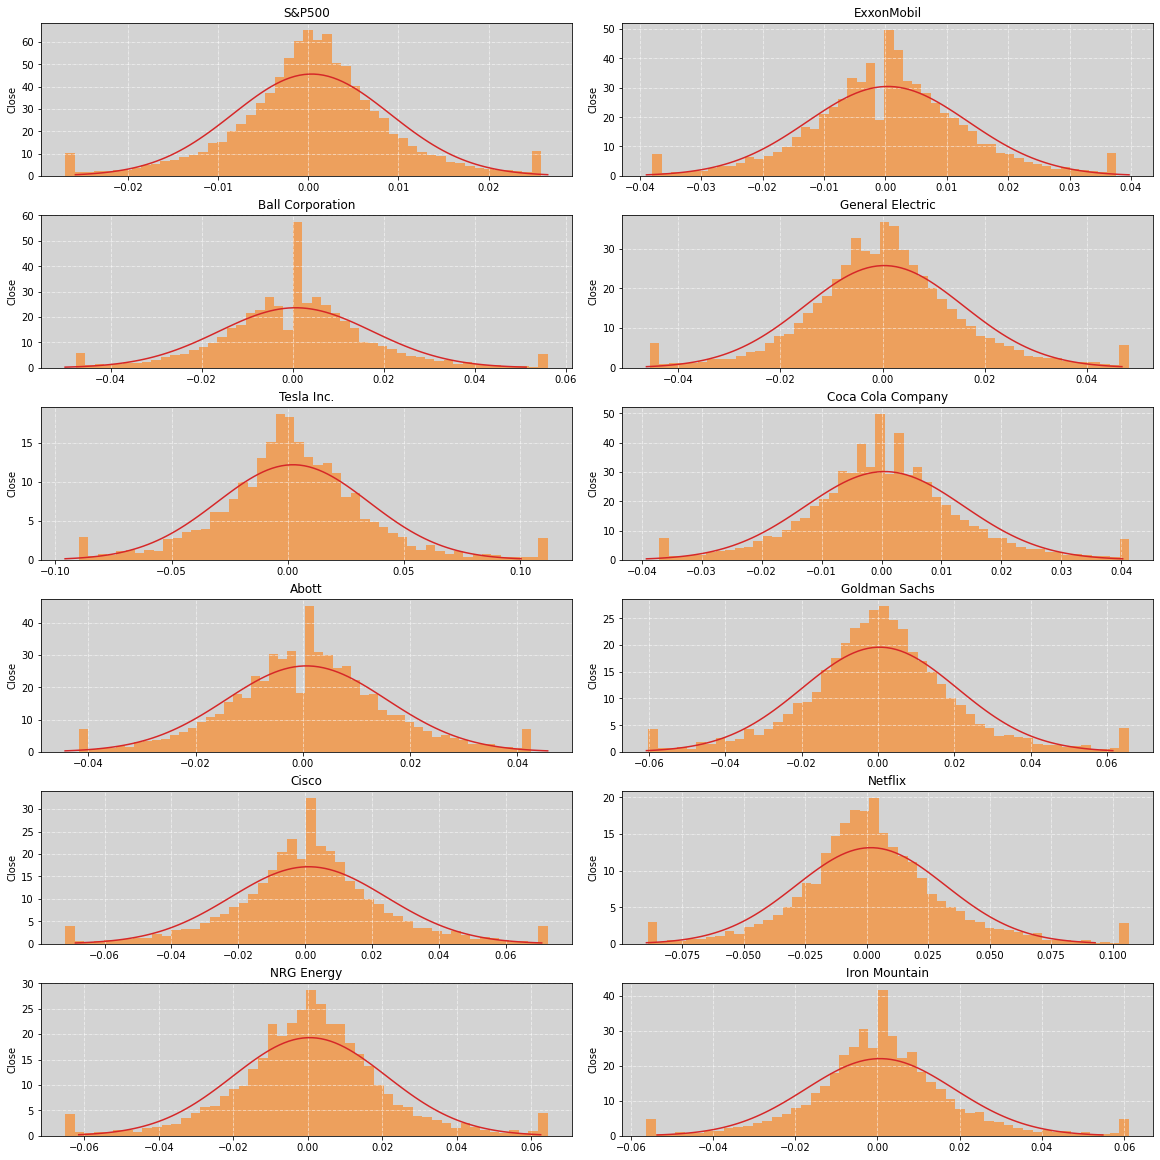

In [36]:
# Plotting returns histograms after clipping (for returns based on closing prices)
plt.figure(figsize=(16, 16), constrained_layout = True)

for iticker in range(len(tickers)):
    # Prepare inputs for normal distribution plot overlay
    mean_val  = df_stock_returns_final_clip[tickers[iticker]]['Close'].mean()
    std_val   = df_stock_returns_final_clip[tickers[iticker]]['Close'].std()
    min_val   = df_stock_returns_final_clip[tickers[iticker]]['Close'].min()
    max_val   = df_stock_returns_final_clip[tickers[iticker]]['Close'].max()
    x_norm    = np.linspace(mean_val-3*std_val, mean_val+3*std_val, 100)  # alternative: np.linspace(min_val, max_val, 100)
    #x_norm    = np.linspace(min_val, max_val, 100)
    y_norm  = scipy.stats.norm.pdf(x_norm,mean_val,std_val) 
    
    # Create subplots
    plt.subplot(6, 2, iticker+1)    
    df_stock_returns_final_clip[tickers[iticker]]['Close'].hist(bins=50, alpha=0.6, density=True, color='tab:orange')
    plt.plot(x_norm, y_norm, color='tab:red', linewidth=1.5)
    
    # Labels and graphics
    plt.xlabel(None)
    plt.ylabel('Close')
    plt.title(names[iticker])
    plt.grid(color='white', linestyle='-.', linewidth=0.5)
    ax = plt.gca()
    ax.set_facecolor('lightgrey')

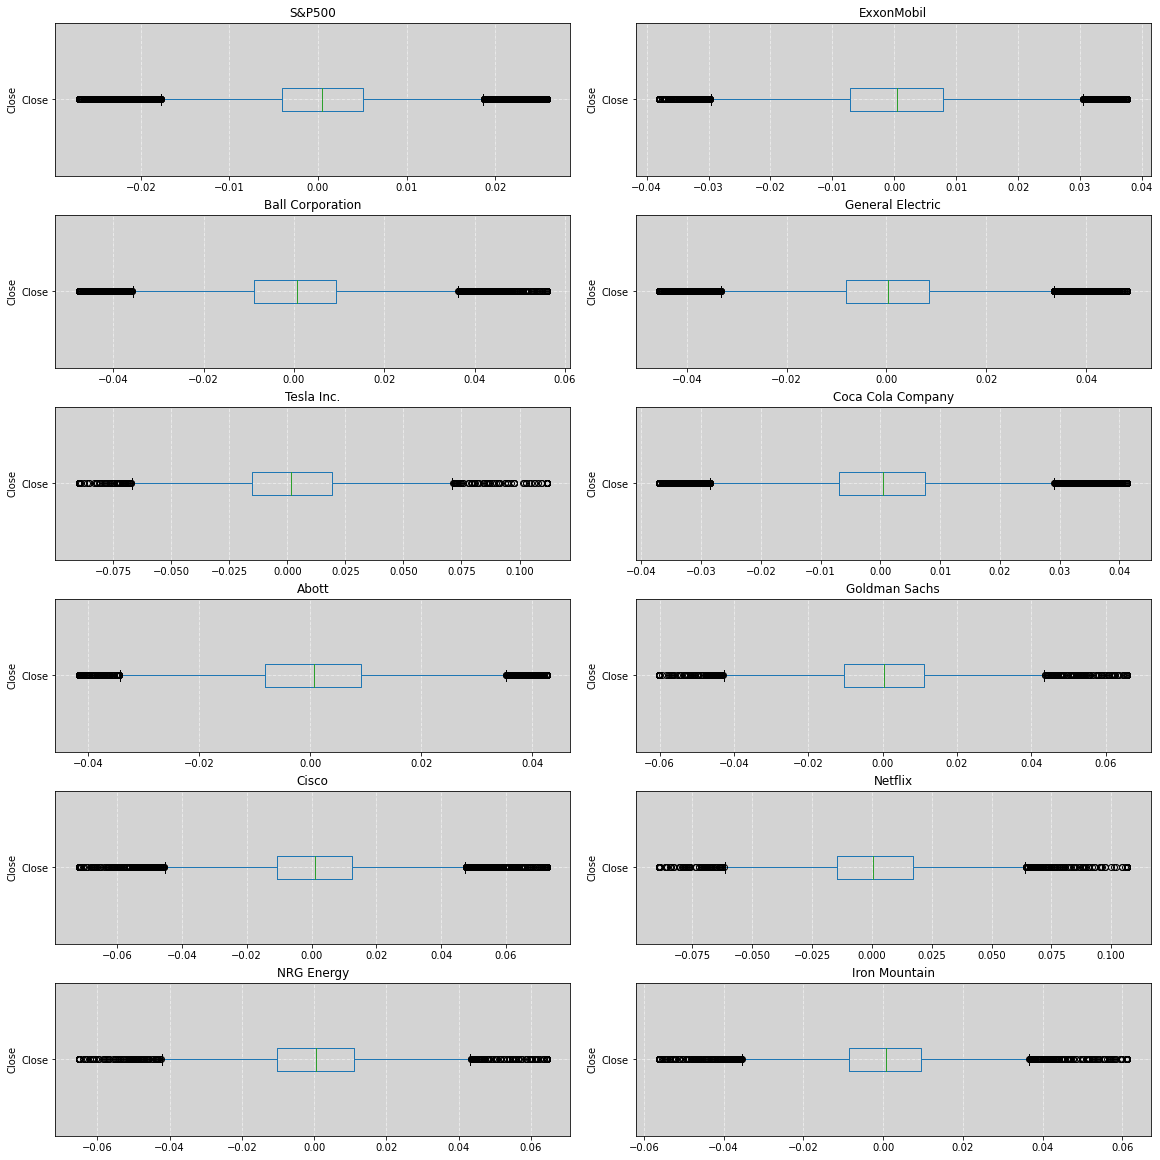

In [37]:
# Plotting returns boxplots after clipping (for returns based on closing prices)
plt.figure(figsize=(16, 16), constrained_layout = True)

for iticker in range(len(tickers)):
    # Create subplots
    plt.subplot(6, 2, iticker+1)
    idf = df_stock_returns_final_clip[tickers[iticker]]
    idf.boxplot('Close',vert=False)
    # Labels and graphics
    plt.xlabel(None)
    plt.ylabel('Close')
    plt.title(names[iticker])
    plt.grid(color='white', linestyle='-.', linewidth=0.5)
    ax = plt.gca()
    ax.set_facecolor('lightgrey')

### a) Normality  
* Create Q–Q plots for each time series. Discuss the results.
* Run normality tests, e.g., Jarque–Bera, Shapiro–Wilk, Anderson–Darling, and D’Agostino K-squared tests. Consider possible input parameters in the applied methods, briefly describe the tests, and discuss your choices and findings. To run these tests, consider scipy.stats (or any other relevant package).

#### qq Plots

In [38]:
import scipy.stats as stats
import matplotlib.pyplot as plt

^GSPC


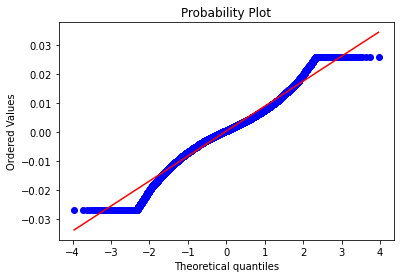

XOM


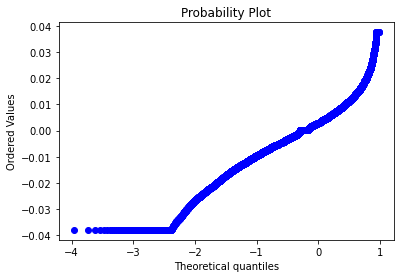

BALL


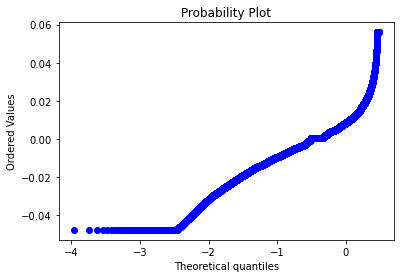

GE


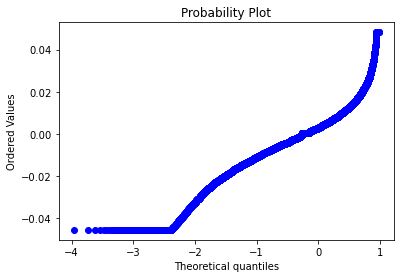

TSLA


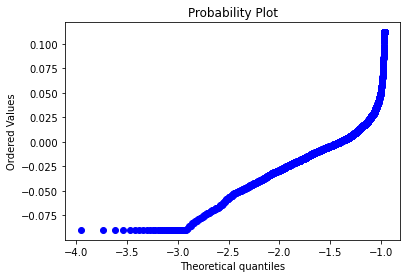

KO


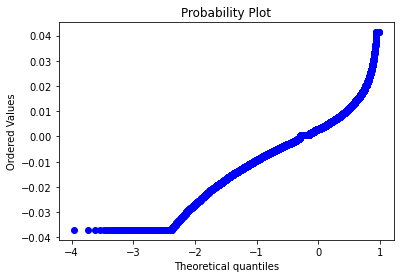

ABT


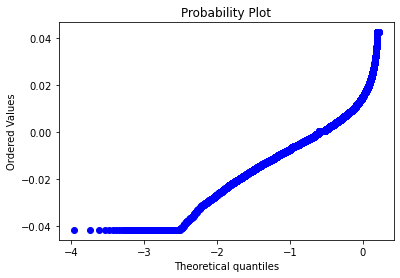

GS


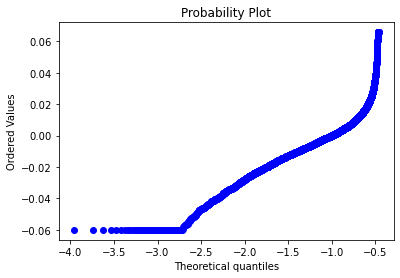

CSCO


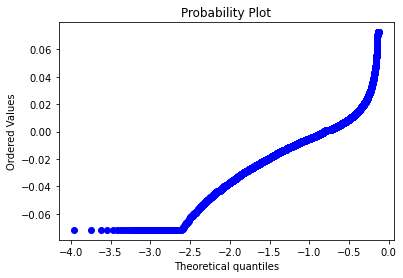

NFLX


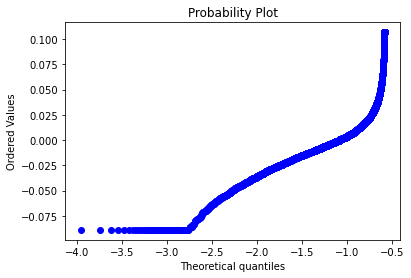

NRG


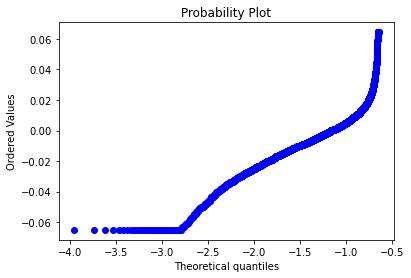

IRM


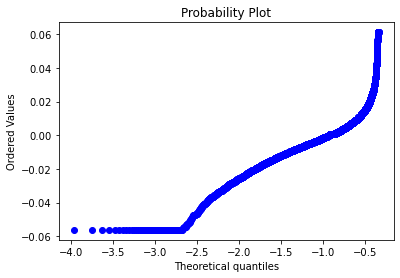

In [39]:
for iticker in range(len(tickers)):
    print(tickers[iticker])
    stats.probplot(df_stock_returns_final_clip[tickers[iticker]]['Close'], dist="norm", plot=py)
    py.show()

#### Normality Tests

In [40]:
#Jarque–Bera

num_nonnormal = 0

for iticker in range(len(tickers)):
    iresult_jbtest = scipy.stats.jarque_bera(df_stock_returns[tickers[iticker]]['Close'].dropna())
    print(tickers[iticker])
    print('JB Statistic: %f' % iresult_jbtest[0])
    print('pvalue: %f' % iresult_jbtest[1])
    print('-'*100)
    
    if iresult_jbtest[1] > 0.05:
        num_nonnormal += 1
        
if num_nonnormal == 0:
  print("None of the stock returns follow normal distribution.")      

^GSPC
JB Statistic: 320665.126879
pvalue: 0.000000
----------------------------------------------------------------------------------------------------
XOM
JB Statistic: 115202.826455
pvalue: 0.000000
----------------------------------------------------------------------------------------------------
BALL
JB Statistic: 37530.097674
pvalue: 0.000000
----------------------------------------------------------------------------------------------------
GE
JB Statistic: 46519.423789
pvalue: 0.000000
----------------------------------------------------------------------------------------------------
TSLA
JB Statistic: 3750.180350
pvalue: 0.000000
----------------------------------------------------------------------------------------------------
KO
JB Statistic: 102300.539018
pvalue: 0.000000
----------------------------------------------------------------------------------------------------
ABT
JB Statistic: 10653.745725
pvalue: 0.000000
------------------------------------------------------

In [41]:
#Shapiro–Wilk
# 
#Ho(Accepted): Sample is from the normal distributions.(Po>0.05)
#Ha(Rejected): Sample is not from the normal distributions.

num_nonnormal = 0

for iticker in range(len(tickers)):
    iresult_swtest = scipy.stats.shapiro(df_stock_returns[tickers[iticker]]['Close'].dropna())
    print(tickers[iticker])
    print('Shapiro Wilk Statistic: %f' % iresult_swtest[0])
    print('pvalue: %f' % iresult_swtest[1])
    print('-'*100)
    
    if iresult_swtest[1] > 0.05:
        num_nonnormal += 1
        
if num_nonnormal == 0:
  print("None of the stock returns follow normal distribution.") 

^GSPC
Shapiro Wilk Statistic: 0.896751
pvalue: 0.000000
----------------------------------------------------------------------------------------------------
XOM
Shapiro Wilk Statistic: 0.926351
pvalue: 0.000000
----------------------------------------------------------------------------------------------------
BALL
Shapiro Wilk Statistic: 0.925060
pvalue: 0.000000
----------------------------------------------------------------------------------------------------
GE
Shapiro Wilk Statistic: 0.922182
pvalue: 0.000000
----------------------------------------------------------------------------------------------------
TSLA
Shapiro Wilk Statistic: 0.930423
pvalue: 0.000000
----------------------------------------------------------------------------------------------------
KO
Shapiro Wilk Statistic: 0.928127
pvalue: 0.000000
----------------------------------------------------------------------------------------------------
ABT
Shapiro Wilk Statistic: 0.959636
pvalue: 0.000000
--------------

c:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\morestats.py:1760: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


In [42]:
#Anderson Darling Test

num_nonnormal = 0

for iticker in range(len(tickers)):
    iresult_adtest = scipy.stats.anderson(df_stock_returns[tickers[iticker]]['Close'].dropna(), dist= 'norm')
    print(tickers[iticker])
    print('Anderson Darling Statistic: %f' % iresult_adtest[0])
    vector = np.vectorize(np.int_)
    print('pvalue:')
    print(*iresult_adtest[1], sep = ", ")
    print('significance level:')
    print(*iresult_adtest[2], sep = ", ")
    print('-'*100)
    
    if iresult_adtest[0] > 0.641:
        num_nonnormal += 1
        
if num_nonnormal == 0:
  print("None of the stock returns follow normal distribution.") 

^GSPC
Anderson Darling Statistic: 288.594211
pvalue:
0.576, 0.656, 0.787, 0.918, 1.092
significance level:
15.0, 10.0, 5.0, 2.5, 1.0
----------------------------------------------------------------------------------------------------
XOM
Anderson Darling Statistic: 136.679211
pvalue:
0.576, 0.656, 0.787, 0.918, 1.092
significance level:
15.0, 10.0, 5.0, 2.5, 1.0
----------------------------------------------------------------------------------------------------
BALL
Anderson Darling Statistic: 167.273792
pvalue:
0.576, 0.656, 0.787, 0.918, 1.092
significance level:
15.0, 10.0, 5.0, 2.5, 1.0
----------------------------------------------------------------------------------------------------
GE
Anderson Darling Statistic: 196.281602
pvalue:
0.576, 0.656, 0.787, 0.918, 1.092
significance level:
15.0, 10.0, 5.0, 2.5, 1.0
----------------------------------------------------------------------------------------------------
TSLA
Anderson Darling Statistic: 42.385898
pvalue:
0.575, 0.655, 0.786

In [43]:
#D’Agostino K-squared tests

num_nonnormal = 0

for iticker in range(len(tickers)):
    iresult_daktest = scipy.stats.normaltest(df_stock_returns[tickers[iticker]]['Close'].dropna(), nan_policy='omit')
    print(tickers[iticker])
    print('D’Agostino K-squared: %f' % iresult_daktest[0])
    print('p value: %f' % iresult_daktest[1])
        
    if iresult_daktest[1] < 1e-3:
        num_nonnormal += 1
        
if num_nonnormal > 0:
  print("None of the stock returns follow normal distribution.") 

^GSPC
D’Agostino K-squared: 5581.776803
p value: 0.000000
XOM
D’Agostino K-squared: 3116.372578
p value: 0.000000
BALL
D’Agostino K-squared: 2016.493777
p value: 0.000000
GE
D’Agostino K-squared: 2499.169689
p value: 0.000000
TSLA
D’Agostino K-squared: 427.277811
p value: 0.000000
KO
D’Agostino K-squared: 3035.088097
p value: 0.000000
ABT
D’Agostino K-squared: 1176.488469
p value: 0.000000
GS
D’Agostino K-squared: 1610.489111
p value: 0.000000
CSCO
D’Agostino K-squared: 1280.360547
p value: 0.000000
NFLX
D’Agostino K-squared: 1229.093999
p value: 0.000000
NRG
D’Agostino K-squared: 1489.351687
p value: 0.000000
IRM
D’Agostino K-squared: 1173.472932
p value: 0.000000
None of the stock returns follow normal distribution.


### b) Multivariate Analysis

* Compute and visualize (e.g., using a heatmap) the correlation matrix. Discuss your findings, i.e., try to provide a rationale why some pairs of stocks might have higher correlation that others. To answer this question, select up to five representative figures from the correlation matrix.
* Calculate the [Mahalanobis distance (MD)](https://en.wikipedia.org/wiki/Mahalanobis_distance) for the selected eleven stocks (i.e., exclude the S&P 500 index). Download daily time series of the CBOE volatility index (VIX), and plot the MD and VIX in the same graph. Discuss your findings.

In [83]:
# Creating data frames for correlation plotting 
fields_prices    = ['Close']
fields_all       = df_stock_prices.columns.get_level_values(1).drop_duplicates().tolist()
fields_drop      = list(set(fields_all) - set(fields_prices))
print(fields_all)
print(fields_drop)

df_stock_prices_corr = df_stock_prices.copy()
df_stock_prices_corr = df_stock_prices_corr.drop(fields_drop, level=1, axis=1)
df_stock_returns_corr = df_stock_prices_corr.pct_change(fill_method=None)
display(df_stock_prices_corr)
display(df_stock_returns_corr)

['Open', 'High', 'Low', 'Close', 'Adj Close']
['Low', 'Open', 'High', 'Adj Close']


IRM        NFLX        ^GSPC        ABT          GS  \
                Close       Close        Close      Close       Close   
Date                                                                    
1950-01-03        NaN         NaN    16.660000        NaN         NaN   
1950-01-04        NaN         NaN    16.850000        NaN         NaN   
1950-01-05        NaN         NaN    16.930000        NaN         NaN   
1950-01-06        NaN         NaN    16.980000        NaN         NaN   
1950-01-09        NaN         NaN    17.080000        NaN         NaN   
...               ...         ...          ...        ...         ...   
2022-09-26  44.730000  224.070007  3655.040039  99.839996  294.619995   
2022-09-27  43.590000  224.360001  3647.290039  98.330002  291.380005   
2022-09-28  44.910000  245.199997  3719.040039  98.720001  300.790009   
2022-09-29  43.810001  239.710007  3640.469971  98.290001  296.109985   
2022-09-30  43.970001  235.440002  3585.620117  96.760002  293.049988   

                 BALL       CSCO         GE        TSLA        NRG        XOM  \
                Close      Close      Close       Close      Close      Close   
Date                                                                            
1950-01-03        NaN        NaN        NaN         NaN        NaN        NaN   
1950-01-04        NaN        NaN        NaN         NaN        NaN        NaN   
1950-01-05        NaN        NaN        NaN         NaN        NaN        NaN   
1950-01-06        NaN        NaN        NaN         NaN        NaN        NaN   
1950-01-09        NaN        NaN        NaN         NaN        NaN        NaN   
...               ...        ...        ...         ...        ...        ...   
2022-09-26  48.310001  40.580002  64.349998  276.010010  39.389999  83.980003   
2022-09-27  47.490002  40.520000  64.470001  282.940002  39.389999  85.739998   
2022-09-28  49.230000  41.340000  64.459999  287.809998  40.250000  88.860001   
2022-09-29  47.650002  40.570000  62.730000  268.209991  39.180000  88.680000   
2022-09-30  48.320000  40.000000  61.910000  265.250000  38.270000  87.309998   

                   KO  
                Close  
Date                   
1950-01-03        NaN  
1950-01-04        NaN  
1950-01-05        NaN  
1950-01-06        NaN  
1950-01-09        NaN  
...               ...  
2022-09-26  57.869999  
2022-09-27  56.380001  
2022-09-28  56.980000  
2022-09-29  56.570000  
2022-09-30  56.020000  

[18306 rows x 12 columns]

IRM      NFLX     ^GSPC       ABT        GS      BALL  \
               Close     Close     Close     Close     Close     Close   
Date                                                                     
1950-01-03       NaN       NaN       NaN       NaN       NaN       NaN   
1950-01-04       NaN       NaN  0.011405       NaN       NaN       NaN   
1950-01-05       NaN       NaN  0.004748       NaN       NaN       NaN   
1950-01-06       NaN       NaN  0.002953       NaN       NaN       NaN   
1950-01-09       NaN       NaN  0.005889       NaN       NaN       NaN   
...              ...       ...       ...       ...       ...       ...   
2022-09-26 -0.040129 -0.010335 -0.010341 -0.008343 -0.024340 -0.016890   
2022-09-27 -0.025486  0.001294 -0.002120 -0.015124 -0.010997 -0.016974   
2022-09-28  0.030282  0.092886  0.019672  0.003966  0.032295  0.036639   
2022-09-29 -0.024493 -0.022390 -0.021126 -0.004356 -0.015559 -0.032094   
2022-09-30  0.003652 -0.017813 -0.015067 -0.015566 -0.010334  0.014061   

                CSCO        GE      TSLA       NRG       XOM        KO  
               Close     Close     Close     Close     Close     Close  
Date                                                                    
1950-01-03       NaN       NaN       NaN       NaN       NaN       NaN  
1950-01-04       NaN       NaN       NaN       NaN       NaN       NaN  
1950-01-05       NaN       NaN       NaN       NaN       NaN       NaN  
1950-01-06       NaN       NaN       NaN       NaN       NaN       NaN  
1950-01-09       NaN       NaN       NaN       NaN       NaN       NaN  
...              ...       ...       ...       ...       ...       ...  
2022-09-26 -0.001967 -0.003098  0.002470 -0.030519 -0.020641 -0.012457  
2022-09-27 -0.001479  0.001865  0.025108  0.000000  0.020957 -0.025747  
2022-09-28  0.020237 -0.000155  0.017212  0.021833  0.036389  0.010642  
2022-09-29 -0.018626 -0.026838 -0.068101 -0.026584 -0.002026 -0.007196  
2022-09-30 -0.014050 -0.013072 -0.011036 -0.023226 -0.015449 -0.009722  

[18306 rows x 12 columns]

In [87]:
df_stock_prices_corr = df_stock_prices_corr.dropna().corr()
df_stock_returns_corr = df_stock_returns_corr.dropna().corr()

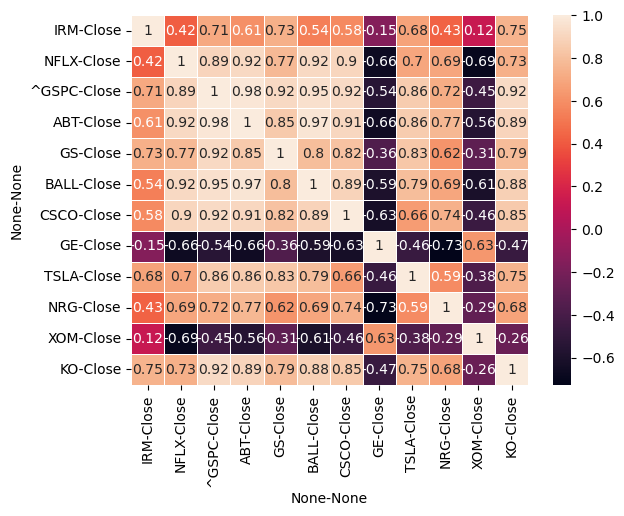

In [88]:
plt.style.use('default')
sns.heatmap(df_stock_prices_corr, annot = True, linewidths = 0.5)
plt.show()

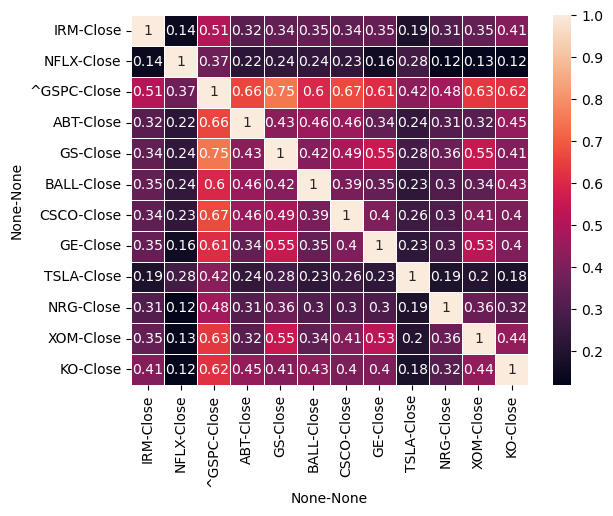

In [89]:
plt.style.use('default')
sns.heatmap(df_stock_returns_corr, annot = True, linewidths = 0.5)
plt.show()

# 2 FRED–MD: A Database for Macroeconomic Research

Consider the Federal Reserve Bank of St. Louis’ monthly database of macroeconomic factors created by [Michael W. McCracken et al](https://research.stlouisfed.org/econ/mccracken/fred-databases/). The data and the associated research paper are provided on the shared drive. The list of all variables and the respective recommended data transformations are listed in the appendix of the paper (pp. 586–588).

In this exercise, you will conduct an exploratory data analysis for a subset of the FRED–MD database. You can use and possibly amend your EDA code generated for the US stock market analysis in the previous exercise. You are free to choose which types of data presentations and statistical testing are relevant for this particular data set. Last but not least, you are most welcome to introduce your own ideas and add other tests and procedures (in which case you might be awarded bonus points). For each of the questions listed below, please provide plots or tables where necessary, justify your choices, and discuss your results.

### a) Data selection: 
From each of the eight data categories presented in the paper select one representative variable.

In [90]:
#import necessary packages and dataset

import pandas as pd
import matplotlib as plt
import matplotlib.pyplot as plt
from scipy.stats.mstats import winsorize
import seaborn as sns
from plotly.subplots import make_subplots
import plotly.graph_objects as go
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import kpss
import numpy as np
import scipy.stats as ss
import statsmodels.api as sm
import pylab as py
df1=pd.read_excel('McCracken_Macro_Dataset_Monthly_2208.xlsx')[['RPI','UNRATE','HOUST','DPCERA3M086SBEA','M1SL','FEDFUNDS','CPIAUCSL','S&P 500']]

For the data out of the set we have selcted to work with the following variables:
* RPI-Real Personal Income
* UNRATE-Civilian Unemployment Rate
* HOUST Housing Starts-Total New Privately Owned
* DPCERA3M086SBEA-Real personal consumption expenditures
* M1SL M1 -Money Stock
* FEDFUNDS-Effective Federal Funds Rate
* CPIAUCSL CPI-All Items
* S&P 500-S&P’s Common Stock Price Index: Composite

as these are the most important economic variables and are easy to interpret.

### (b) High-level overview: 
Present basic information about your data set in tabular or visual form.

In [91]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 764 entries, 0 to 763
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RPI              764 non-null    float64
 1   UNRATE           764 non-null    float64
 2   HOUST            764 non-null    float64
 3   DPCERA3M086SBEA  764 non-null    float64
 4   M1SL             764 non-null    float64
 5   FEDFUNDS         764 non-null    float64
 6   CPIAUCSL         764 non-null    float64
 7   S&P 500          764 non-null    float64
dtypes: float64(8)
memory usage: 47.9 KB


The data seem to be in numerical float 64 format

In [92]:
df1.describe()

RPI      UNRATE        HOUST  DPCERA3M086SBEA          M1SL  \
count    764.000000  764.000000   764.000000       764.000000    764.000000   
mean    8695.443301    5.955236  1431.759162        61.559025   1680.968848   
std     4519.273571    1.670015   389.747961        32.455444   3468.132955   
min        5.000000    2.000000     4.000000         5.000000      6.000000   
25%     4796.404500    4.800000  1196.750000        32.405000    273.350000   
50%     7754.605000    5.700000  1460.500000        54.518500    820.050000   
75%    12718.136000    7.000000  1656.000000        94.294250   1375.475000   
max    21267.506000   14.700000  2494.000000       126.360000  20699.100000   

         FEDFUNDS    CPIAUCSL      S&P 500  
count  764.000000  764.000000   764.000000  
mean     4.773966  132.334682   813.454647  
std      3.684566   78.484292   966.913631  
min      0.050000    6.000000     5.000000  
25%      1.867500   51.375000   100.007500  
50%      4.640000  132.950000   348.000000  
75%      6.565000  202.200000  1254.210000  
max     19.100000  295.328000  4674.770000

In [94]:
fig = make_subplots(rows=8, cols=1)


for i in range(8):
    fig.add_trace(go.Histogram(x=df1.iloc[:,i],name='Histogram of '+df1.columns[i]),col=1,row=i+1)
    
fig.update_layout(height=1600, width=600, title_text="Data histograms")
    
#fig.show()

From the plotted histograms we can initially view that Unemployment Rate and M1 Money supply (cash) have some extreme values in the right hand distribution.

### (c) Data transformations: 
Apply data transformations and run some stationarity tests.

We opted to perform ADF and KPSS tests on raw data, absolute differenced data and relative differenced data.

In [96]:
#raw data ADF
df=pd.DataFrame(columns=['Test statistics','Pvalue','Signifficance','Critical value 5%','Message'],index=df1.columns)

for i in range(df1.shape[1]):
    df.iloc[i,:]=[adfuller(df1.iloc[:,i])[0],adfuller(df1.iloc[:,i])[1],list(adfuller(df1.iloc[:,0])[4].keys())[1],list(adfuller(df1.iloc[:,0])[4].values())[1],['Non stationary' if adfuller(df1.iloc[:,i])[1]>0.05 else 'Stationary' ][0]]
    
df

Test statistics    Pvalue Signifficance Critical value 5%  \
RPI                    1.349136   0.99687            5%         -2.865438   
UNRATE                -3.400218  0.010951            5%         -2.865438   
HOUST                 -3.872358  0.002248            5%         -2.865438   
DPCERA3M086SBEA        2.176758  0.998863            5%         -2.865438   
M1SL                   2.410574  0.999015            5%         -2.865438   
FEDFUNDS              -2.689659  0.075845            5%         -2.865438   
CPIAUCSL                2.20879   0.99889            5%         -2.865438   
S&P 500                2.518512  0.999056            5%         -2.865438   

                        Message  
RPI              Non stationary  
UNRATE               Stationary  
HOUST                Stationary  
DPCERA3M086SBEA  Non stationary  
M1SL             Non stationary  
FEDFUNDS         Non stationary  
CPIAUCSL         Non stationary  
S&P 500          Non stationary

In [98]:
#raw data kpss
import warnings
warnings.filterwarnings('ignore')

df3=pd.DataFrame(columns=['Test stat','Critical value 5%','Message'],index=df1.columns)

for i in range(df1.shape[1]):
    df3.iloc[i,:]=[kpss(df1.iloc[:,i])[0],list(kpss(df1.iloc[:,i])[3].values())[1],['Non stationary' if list(kpss(df1.iloc[:,i])[3].values())[1]<kpss(df1.iloc[:,i])[0]  else 'Stationary'][0]]
    

df3

Test stat Critical value 5%         Message
RPI              3.658523             0.463  Non stationary
UNRATE           0.182322             0.463      Stationary
HOUST            0.499877             0.463  Non stationary
DPCERA3M086SBEA  3.694952             0.463  Non stationary
M1SL             1.345031             0.463  Non stationary
FEDFUNDS          1.48247             0.463  Non stationary
CPIAUCSL         3.746721             0.463  Non stationary
S&P 500          2.857407             0.463  Non stationary

When performing Augmented Dickey Fuller test and KPSS test on data, we can see that in ADF test out of all data sets only Unemployment Rate and Housing starts have stationarity, while all other data sets remain non stationary, and would require to be transformed in order to get the desired characteristic. KPSS returns even stricter conclusions, and leaves only Unemployment Rate as stationary.

In [100]:
#absolute differenced data ADF

df4=pd.DataFrame(columns=['Test statistics','Pvalue','Signifficance','Critical value 5%','Message'],index=df1.columns)

for i in range(df1.shape[1]):
    df4.iloc[i,:]=[adfuller(df1.iloc[:,i].diff()[1:])[0],adfuller(df1.iloc[:,i].diff()[1:])[1],list(adfuller(df1.iloc[:,i].diff()[1:])[4].keys())[1],list(adfuller(df1.iloc[:,i].diff()[1:])[4].values())[1],['Non stationary' if adfuller(df1.iloc[:,i].diff()[1:])[1]>0.05 else 'Stationary' ][0]]
    
df4

Test statistics    Pvalue Signifficance Critical value 5%  \
RPI                   -5.475729  0.000002            5%         -2.865438   
UNRATE               -20.996966       0.0            5%         -2.865345   
HOUST                 -7.176262       0.0            5%         -2.865401   
DPCERA3M086SBEA       -9.160125       0.0            5%         -2.865391   
M1SL                 -25.510009       0.0            5%          -2.86534   
FEDFUNDS              -5.988468       0.0            5%         -2.865433   
CPIAUCSL              -2.834604  0.053498            5%         -2.865412   
S&P 500               -6.459212       0.0            5%         -2.865438   

                        Message  
RPI                  Stationary  
UNRATE               Stationary  
HOUST                Stationary  
DPCERA3M086SBEA      Stationary  
M1SL                 Stationary  
FEDFUNDS             Stationary  
CPIAUCSL         Non stationary  
S&P 500              Stationary

In [102]:
#absolute differenced data kpss

df4=pd.DataFrame(columns=['Test stat','Critical value 5%','Message'],index=df1.columns)

for i in range(df1.shape[1]):
    df4.iloc[i,:]=[kpss(df1.iloc[:,i].diff()[1:])[0],list(kpss(df1.iloc[:,i].diff()[1:])[3].values())[1],['Non stationary' if list(kpss(df1.iloc[:,i].diff()[1:])[3].values())[1]<kpss(df1.iloc[:,i].diff()[1:])[0]  else 'Stationary'][0]]
df4

Test stat Critical value 5%         Message
RPI              0.097754             0.463      Stationary
UNRATE           0.103411             0.463      Stationary
HOUST            0.115039             0.463      Stationary
DPCERA3M086SBEA  0.161401             0.463      Stationary
M1SL              0.46548             0.463  Non stationary
FEDFUNDS         0.074542             0.463      Stationary
CPIAUCSL         0.316978             0.463      Stationary
S&P 500           0.57155             0.463  Non stationary

Upon performing differetiation on the data sets in order to obtain stationarity in the data, while checking the results with ADF we see that we managed to obtain the desired characteristic in all but CPI Index, while KPSS test  returns us non stationarity in S&P500 and Money Suply (Cash).

In [103]:
#relative diffenced  adf


df4=pd.DataFrame(columns=['Test statistics','Pvalue','Signifficance','Critical value 5%','Message'],index=df1.columns)

for i in range(df1.shape[1]):
    df4.iloc[i,:]=[adfuller(df1.iloc[:,i].pct_change()[1:])[0],adfuller(df1.iloc[:,i].pct_change()[1:])[1],list(adfuller(df1.iloc[:,i].diff()[1:])[4].keys())[1],list(adfuller(df1.iloc[:,i].pct_change()[1:])[4].values())[1],['Non stationary' if adfuller(df1.iloc[:,i].pct_change()[1:])[1]>0.05 else 'Stationary' ][0]]
    
df4

Test statistics    Pvalue Signifficance Critical value 5%  \
RPI                   -5.497842  0.000002            5%         -2.865438   
UNRATE               -33.754162       0.0            5%          -2.86534   
HOUST                 -7.452478       0.0            5%         -2.865396   
DPCERA3M086SBEA       -9.038929       0.0            5%         -2.865386   
M1SL                -255.438968       0.0            5%          -2.86534   
FEDFUNDS              -4.138097  0.000837            5%         -2.865412   
CPIAUCSL              -3.183916  0.020935            5%         -2.865412   
S&P 500              -10.393022       0.0            5%         -2.865366   

                    Message  
RPI              Stationary  
UNRATE           Stationary  
HOUST            Stationary  
DPCERA3M086SBEA  Stationary  
M1SL             Stationary  
FEDFUNDS         Stationary  
CPIAUCSL         Stationary  
S&P 500          Stationary

In [105]:
#relative diffenced KPSS 

df4=pd.DataFrame(columns=['Test stat','Critical value 5%','Message'],index=df1.columns)

for i in range(df1.shape[1]):
    df4.iloc[i,:]=[kpss(df1.iloc[:,i].pct_change()[1:])[0],list(kpss(df1.iloc[:,i].pct_change()[1:])[3].values())[1],['Non stationary' if list(kpss(df1.iloc[:,i].pct_change()[1:])[3].values())[1]<kpss(df1.iloc[:,i].pct_change()[1:])[0]  else 'Stationary'][0]]

df4 

Test stat Critical value 5%     Message
RPI              0.333438             0.463  Stationary
UNRATE           0.116157             0.463  Stationary
HOUST             0.33333             0.463  Stationary
DPCERA3M086SBEA  0.377349             0.463  Stationary
M1SL             0.290213             0.463  Stationary
FEDFUNDS         0.194612             0.463  Stationary
CPIAUCSL         0.361673             0.463  Stationary
S&P 500          0.305876             0.463  Stationary

When performing relative differentiation both test confirm that all the data is stationary.

### (d) Missing observations: 
Impute missing values using your preferred approach. If there are no missing values in your data set, randomly remove some observations just for this part of the exercise. Justify your choice(s).

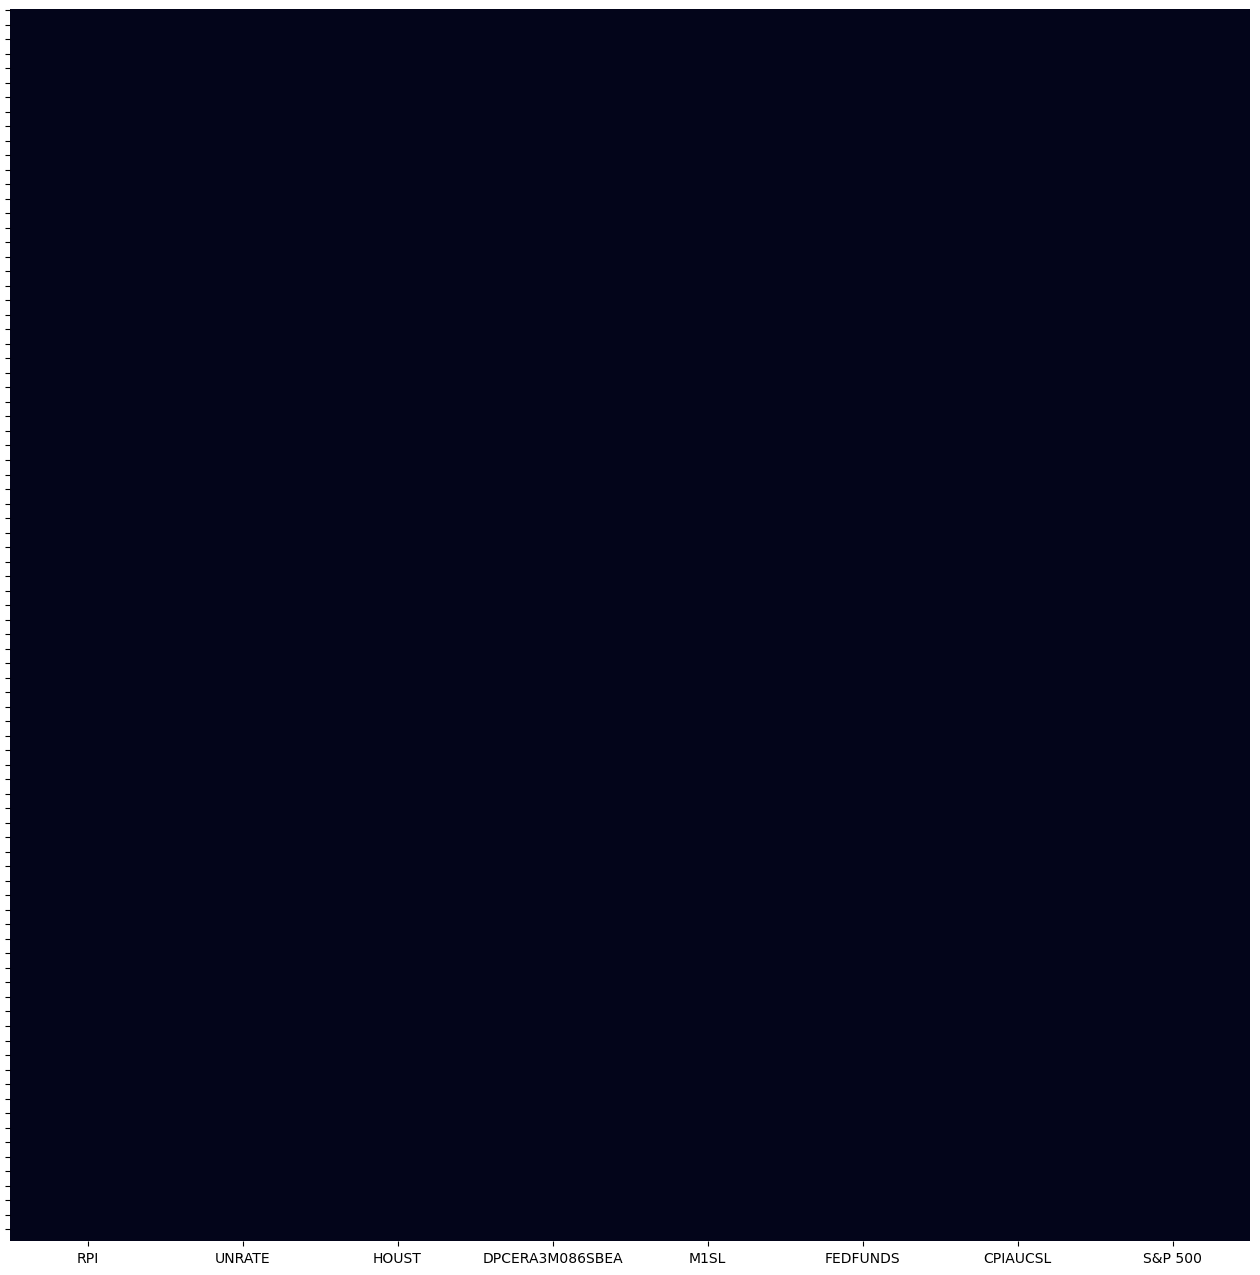

In [107]:
#visual 

plt.figure(figsize=(16, 16))
heatmap_returns = sns.heatmap(df1.isnull(), cbar=False)
heatmap_returns.set_yticklabels([])
plt.show()

The initial plot shows that there are no missing values in the data. And to confirm it the tabular representation is below.

In [108]:
#tabular
df1.isnull().sum()

RPI                0
UNRATE             0
HOUST              0
DPCERA3M086SBEA    0
M1SL               0
FEDFUNDS           0
CPIAUCSL           0
S&P 500            0
dtype: int64

We will for the sake of exercise randomly impute the missing data, and on average each column will have 10% of missing values.

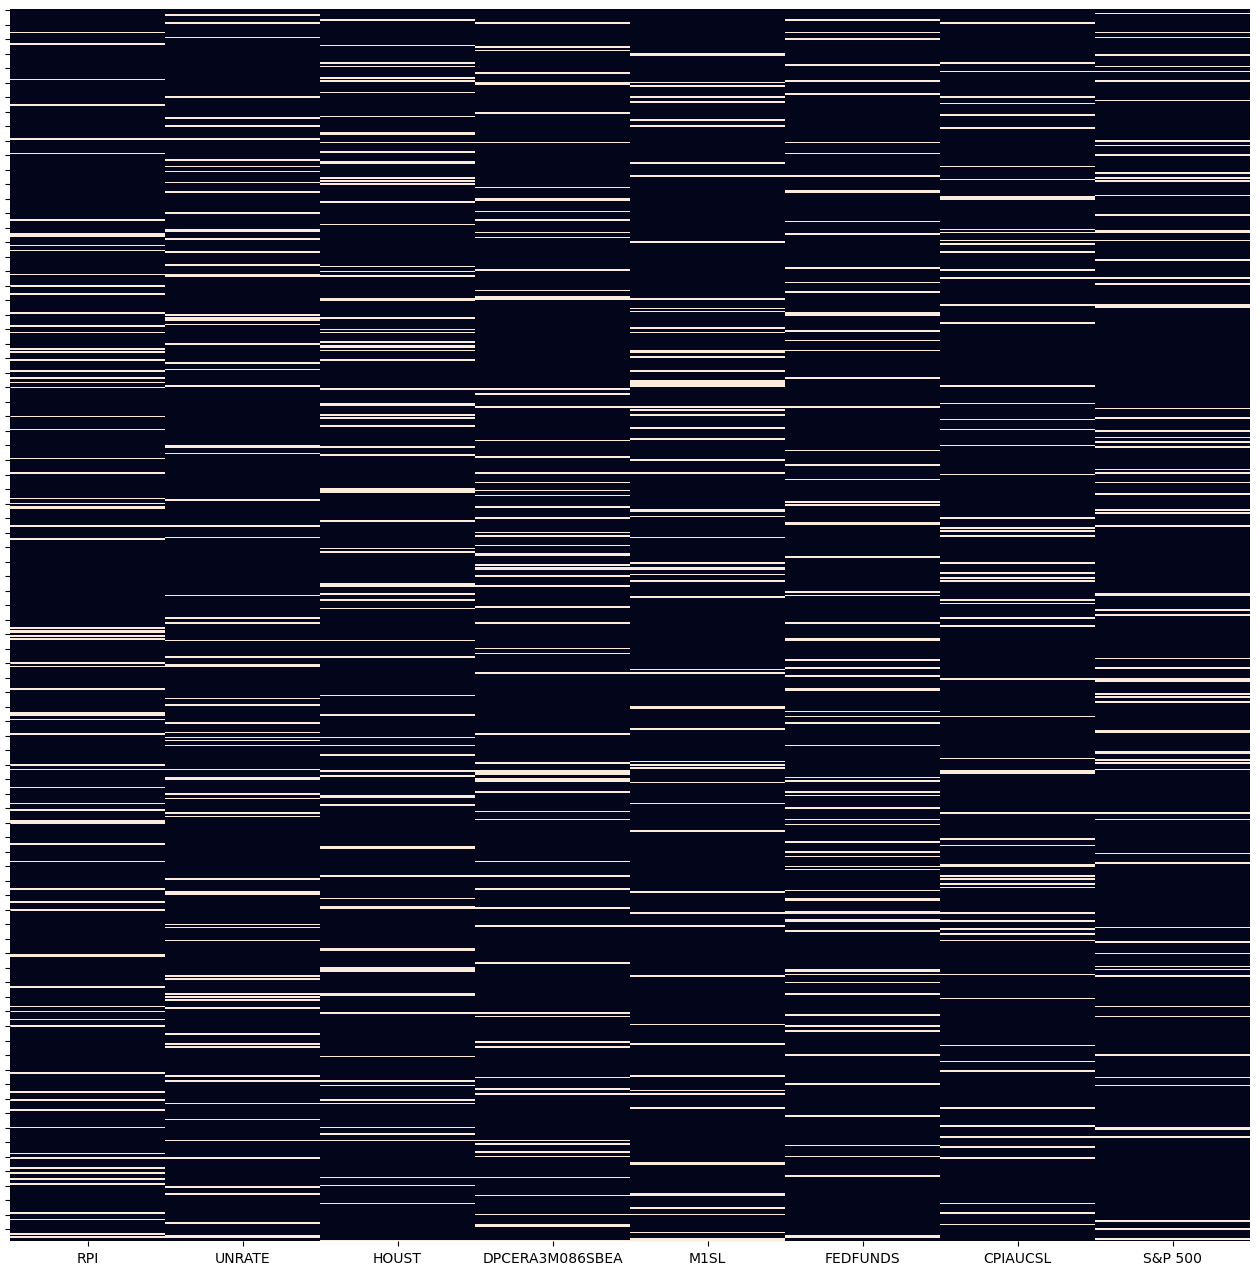

In [109]:
p = 0.1 #percentage missing data required
mask = np.random.choice([True, False], size=df1.shape, p=[p,1-p])
new_df = df1.mask(mask)
#print(new_df)

plt.figure(figsize=(16, 16))
heatmap_returns = sns.heatmap(new_df.isnull(), cbar=False)
heatmap_returns.set_yticklabels([])
plt.show()

In [110]:
fig=go.Figure()

fig.add_trace(go.Bar(y=new_df.isnull().sum(),x=new_df.isnull().sum().index,text=new_df.isnull().sum(),
            textposition='auto'))

In [111]:
new_df.isnull().sum()

RPI                80
UNRATE             81
HOUST              89
DPCERA3M086SBEA    78
M1SL               71
FEDFUNDS           81
CPIAUCSL           70
S&P 500            76
dtype: int64

We will fill the missing data with median, since if the distribution is simetric then mean equals median. However, if distribution is not simetric then mean is not equal to median and in that case median is better measure of central tendency.

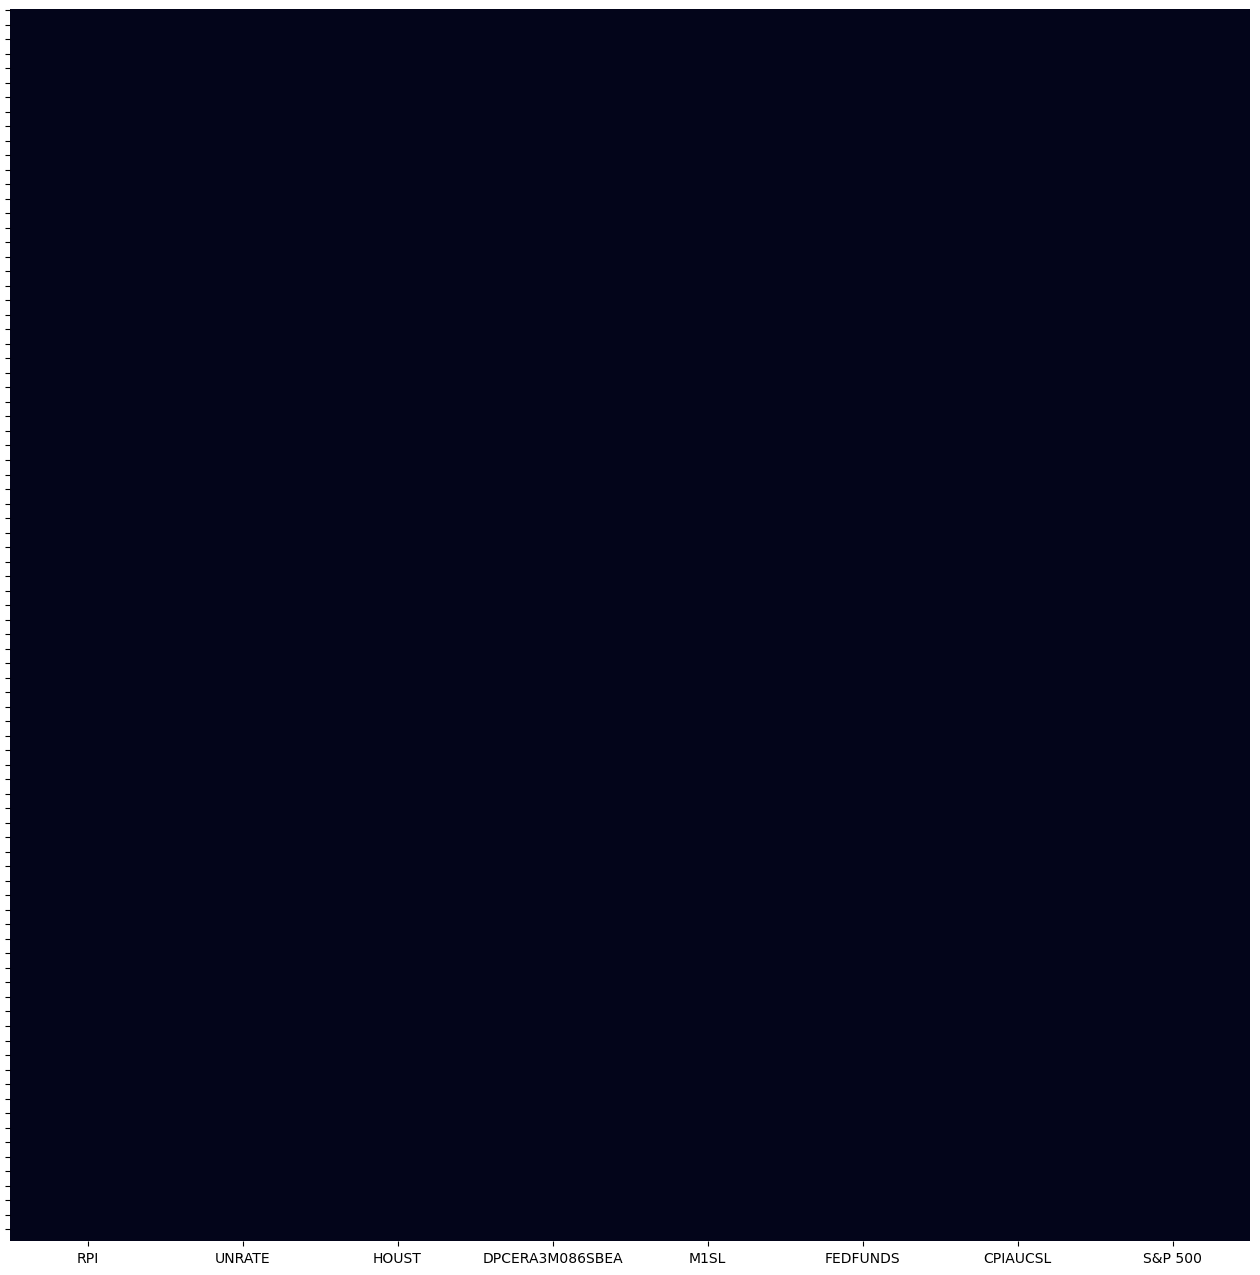

In [112]:
new_df.fillna(new_df.median().round(1), inplace=True) # fill in with median

#no missing values

import seaborn as sns
plt.figure(figsize=(16, 16))
heatmap_returns = sns.heatmap(new_df.isnull(), cbar=False)
heatmap_returns.set_yticklabels([])
plt.show()

### (e) Outliers: 
Implement at least one approach for detection of outliers. Justify your choices (even if you do not remove any outliers).

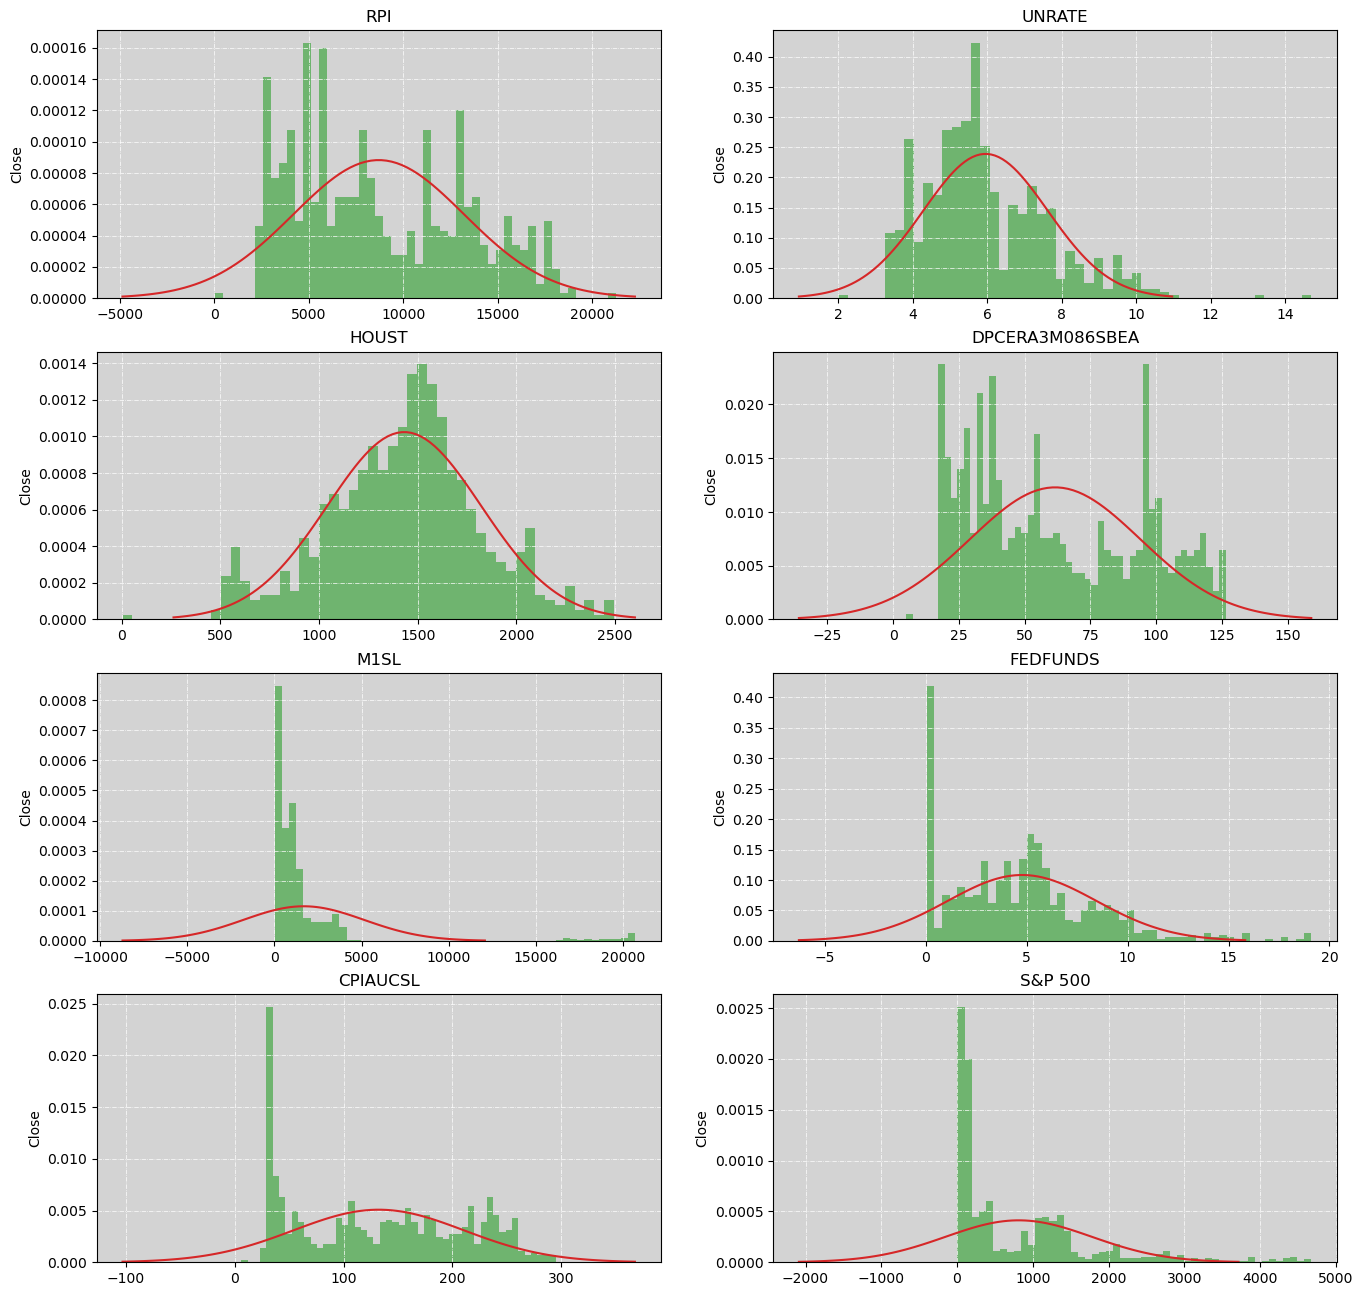

In [113]:
#visuals

#histograms
plt.figure(figsize=(16, 16))

for iticker in range(df1.shape[1]):
    # Prepare inputs for normal distribution plot overlay
    mean_val  = df1.iloc[:,iticker].mean()
    std_val   = df1.iloc[:,iticker].std()
    min_val   = df1.iloc[:,iticker].min()
    max_val   = df1.iloc[:,iticker].max()
    x_norm    = np.linspace(mean_val-3*std_val, mean_val+3*std_val, 100)  # alternative: np.linspace(min_val, max_val, 100)
    #x_norm    = np.linspace(min_val, max_val, 100)
    y_norm  = ss.norm.pdf(x_norm,mean_val,std_val) 
    
    
    # Create subplots
    plt.subplot(4,2,iticker+1)    
    df1.iloc[:,iticker].hist(bins=50, alpha=0.6, density=True, color='tab:green')
    plt.plot(x_norm, y_norm, color='tab:red', linewidth=1.5)
    
    # Labels and graphics
    plt.xlabel(None)
    plt.ylabel('Close')
    plt.title(df1.columns[iticker])
    plt.grid(color='white', linestyle='-.', linewidth=0.5)
    ax = plt.gca()
    ax.set_facecolor('lightgrey')

In [114]:
a=[]
for i in range(1,5):
    for j in range(1,3):
        a.append([i,j])

In [115]:
#box plots

fig = make_subplots(rows=4, cols=2)


for i in range(8):
    fig.add_trace(go.Box(y=df1.iloc[:,i],name='Histogram of '+df1.columns[i]),col=a[i][1],row=a[i][0])
    
fig.update_layout(height=1200, width=800, title_text="Title per column")
    
fig.show()

We can detect outliers present by fat * beyond whiskers in boxplot for Uneployment rate, M1 money in stock, Federal funds rate, Household expenditures. For M1 as we have large outliers, we will remove all the values that are higher than 5k. For Unemployment rate we will remove all the values bigger than 10% ( presumed state for the normal economy). For SP500 we wont remove outliers, since its quite normal that stock prices have heavy tails. For Federal funds returns the outliers are not that extreme

In code below we present the trimmed data, so the boxplot would contain 1. and 3. quantil (25% and 75%), while the whisker borders represent min and max value, which as outliers were out of the normal distribution. By trimming data/windsorizing the the data we obtain a certain thickness in the boxplot as it moves the value toward the center of the distribution.

In [116]:
#removing outliers

#data trimming

a=df1['UNRATE'][df1['UNRATE']<np.percentile(df1['UNRATE'], 75)+(1.5*(np.percentile(df1['UNRATE'], 75)-np.percentile(df1['UNRATE'], 25)))]

b=df1['M1SL'][df1['M1SL']<np.percentile(df1['M1SL'], 75)+(1.5*(np.percentile(df1['M1SL'], 75)-np.percentile(df1['M1SL'], 25)))]



fig = make_subplots(rows=1, cols=2)


fig.add_trace(go.Box(y=a,name='Unemployment without outliers'),row=1,col=2)

fig.add_trace(go.Box(y=b,name='M1SL without outliers'),row=1,col=1)

In [117]:
#vindorising


fig = make_subplots(rows=1, cols=2)


fig.add_trace(go.Box(y=winsorize(df1['UNRATE'],(0.1,0.1)),name='Unemployment without outliers'),row=1,col=2)

fig.add_trace(go.Box(y=winsorize(df1['M1SL'],(0.1,0.1)),name='M1SL without outliers'),row=1,col=1)

### (f) Normality: 
Explore (i.e., visually and formally by using statistical tools) if the data are normally distributed.

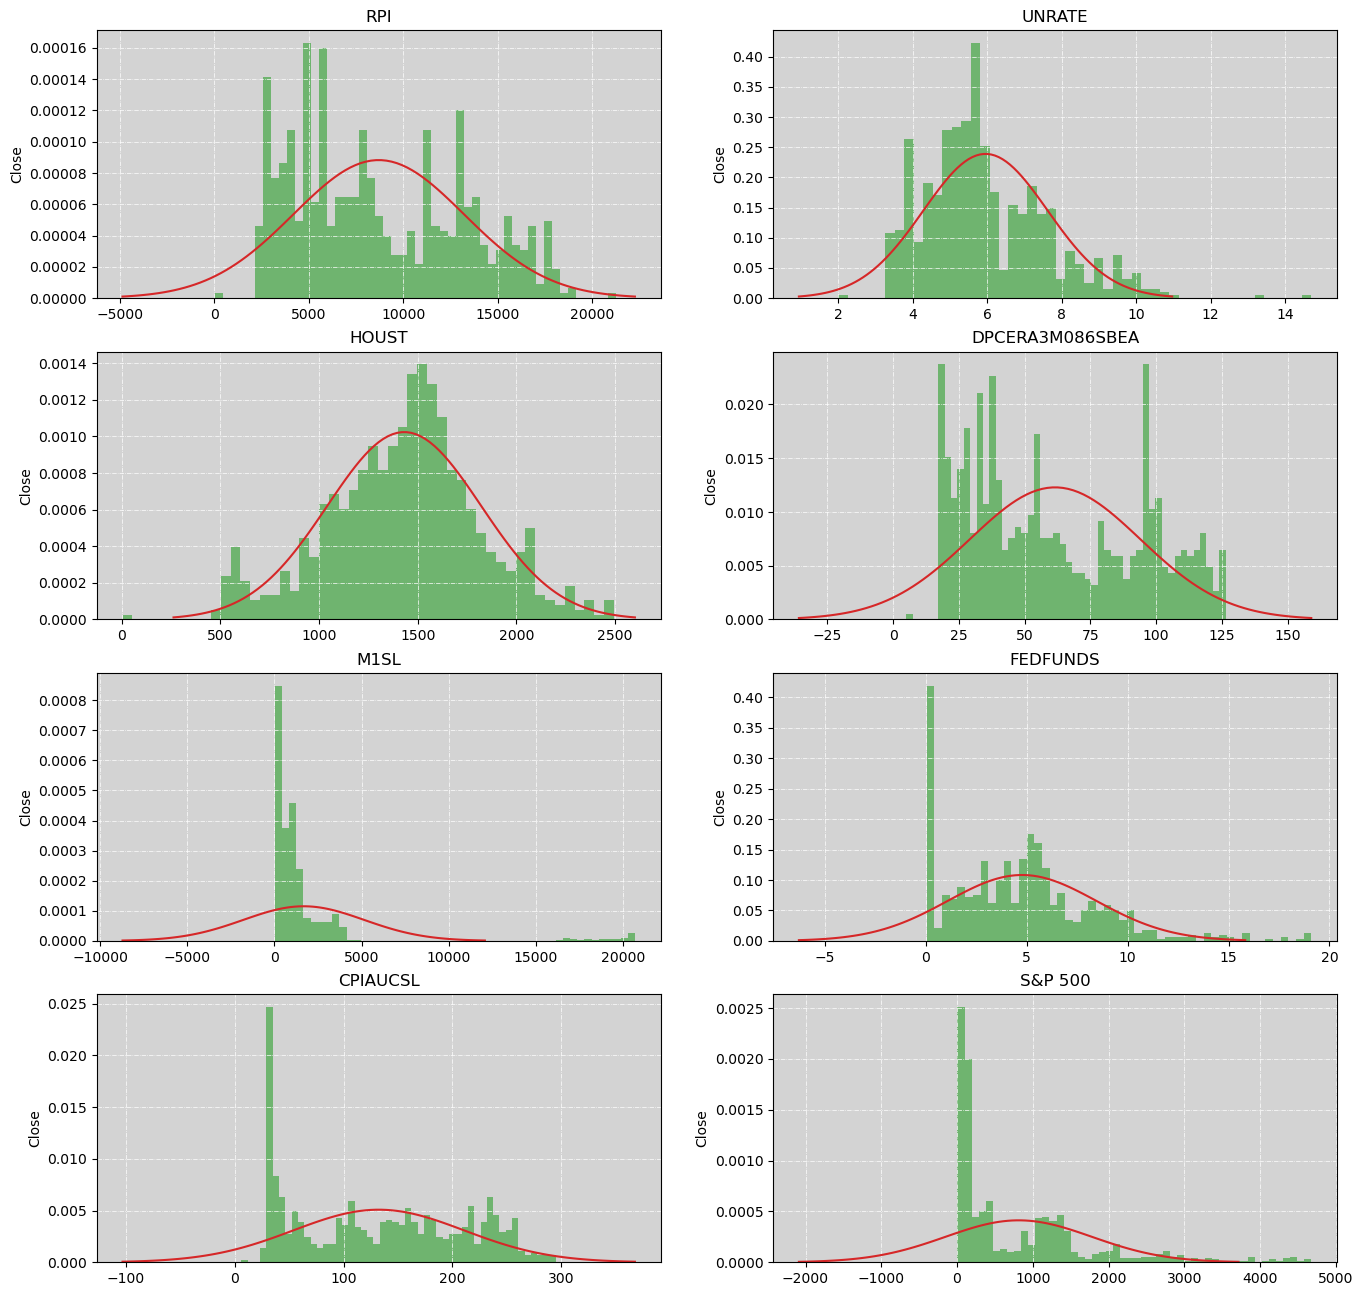

In [118]:
#visuals

#histogram

plt.figure(figsize=(16, 16))

for iticker in range(df1.shape[1]):
    # Prepare inputs for normal distribution plot overlay
    mean_val  = df1.iloc[:,iticker].mean()
    std_val   = df1.iloc[:,iticker].std()
    min_val   = df1.iloc[:,iticker].min()
    max_val   = df1.iloc[:,iticker].max()
    x_norm    = np.linspace(mean_val-3*std_val, mean_val+3*std_val, 100)  # alternative: np.linspace(min_val, max_val, 100)
    #x_norm    = np.linspace(min_val, max_val, 100)
    y_norm  = ss.norm.pdf(x_norm,mean_val,std_val) 
    
    
    # Create subplots
    plt.subplot(4,2,iticker+1)    
    df1.iloc[:,iticker].hist(bins=50, alpha=0.6, density=True, color='tab:green')
    plt.plot(x_norm, y_norm, color='tab:red', linewidth=1.5)
    
    # Labels and graphics
    plt.xlabel(None)
    plt.ylabel('Close')
    plt.title(df1.columns[iticker])
    plt.grid(color='white', linestyle='-.', linewidth=0.5)
    ax = plt.gca()
    ax.set_facecolor('lightgrey')

We will now proceed to ploting qq plots, which provide an indication of univariate normality of the dataset.  
Since normal distribution supposes skewnes equal to 0 and kurtosis equal to 3, if we plot qq plot and the data are normaly distributed, then the blue points will fall on the 45-degree reference line (red line). If the data is not normally distributed, the points will deviate from the reference line.

RPI


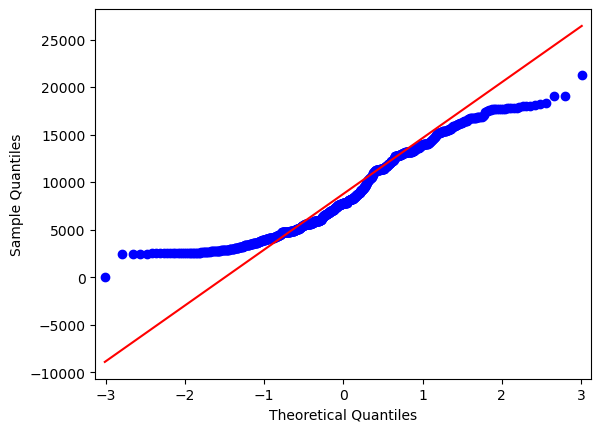

UNRATE


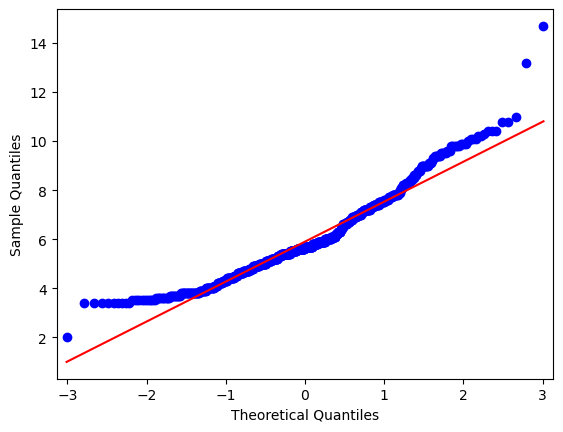

HOUST


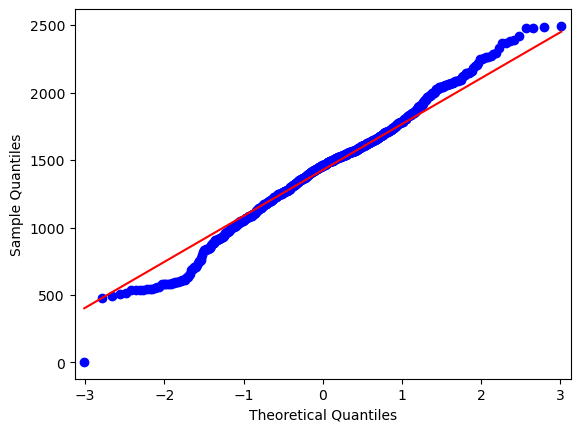

DPCERA3M086SBEA


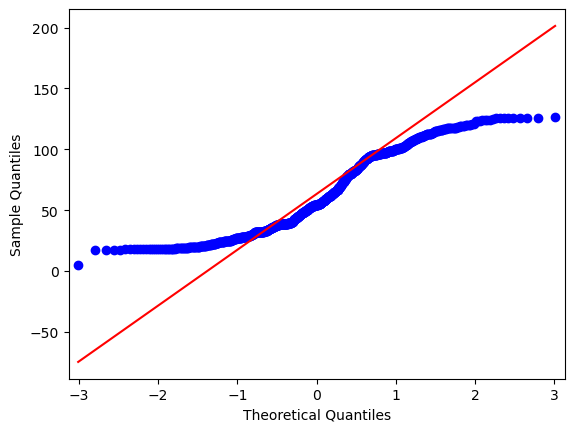

M1SL


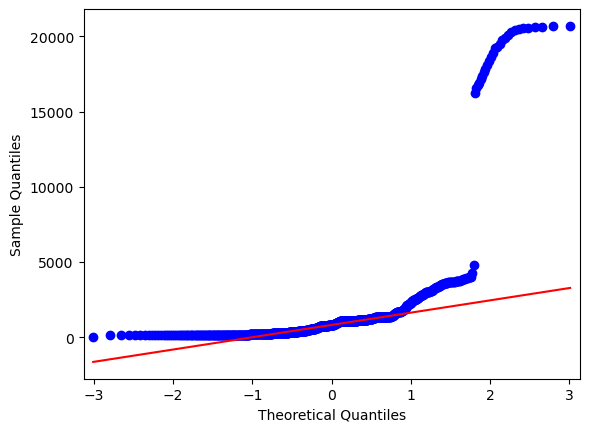

FEDFUNDS


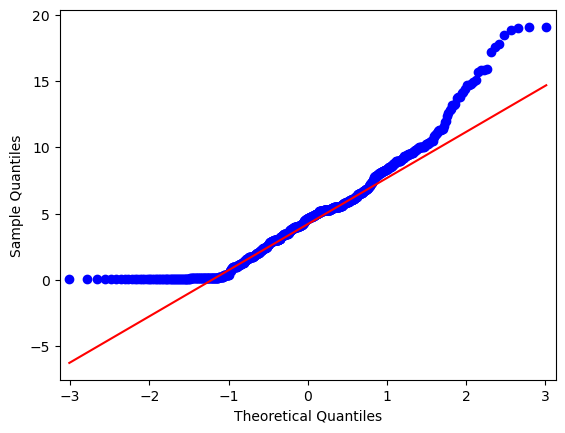

CPIAUCSL


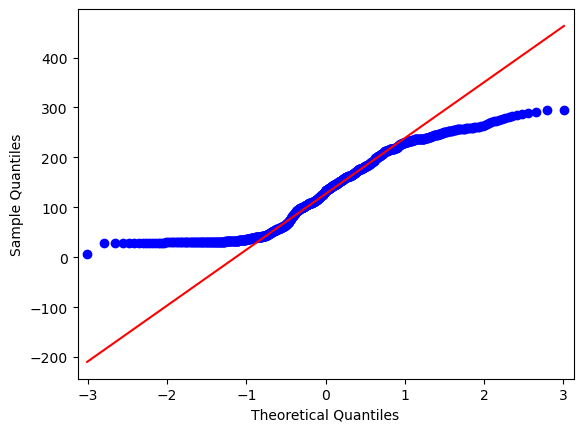

S&P 500


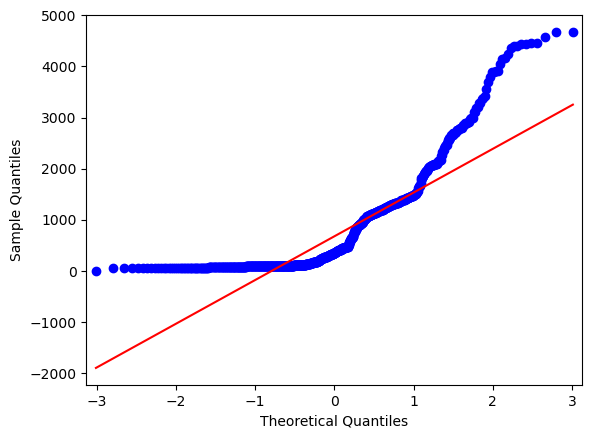

In [119]:
#qqplot

for i in range(8):
    print(df1.columns[i])
    sm.qqplot(df1.iloc[:,i], line ='q')
    py.show()


The results from qq plots indicate that:
* the RPI data is heavy tailed
* Unemployment rate a bit more normally distributed with heavier tails
* Housing data is light tailed following the normal distribution
* Real personal consumption expenditures data is heavy tailed
* M1 money supply data suggest bimodalness in the data or gap in values
* Federal Funds Effective Rate extremly heavy tails
* CPI index suggests some heavier tails
* S&P500 extremly heavy tails

Further test: JB test tests whether the skewness of distribution is 0 and kurstosis is 3 with following hypotheses:  
The H0 skew of distribution is 0 and kurstosis is 3 hence data are normally disributed  
The H1 skew of distribution is not 0 and kurstosis is not 3 hence data are not normally disributed  
Which we will present in table:

In [120]:
df_sk=pd.DataFrame([df1.skew(),df1.kurtosis()]).T

df_sk.columns=['Skewness','Kurtosis']

df_sk



Skewness   Kurtosis
RPI              0.423891  -0.984224
UNRATE           0.904173   1.178637
HOUST           -0.129941   0.225097
DPCERA3M086SBEA  0.357414  -1.213211
M1SL             4.502261  20.170666
FEDFUNDS         0.965540   1.318209
CPIAUCSL         0.149548  -1.305970
S&P 500          1.708944   2.865036

We spot huge deviation in M1SL, an enormous skewness and kurtosis, which is visible from the following test as well.

In [121]:
df = pd.DataFrame(columns=['Length of the sample data', 'Test Statistic', 'p-value','Decision'], index=df1.columns)
for i in range(df1.shape[1]):
    df.iloc[i,:]=[len(df1.iloc[:,i]), ss.jarque_bera(df1.iloc[:,i])[0], ss.jarque_bera(df1.iloc[:,i])[1],['Data are normaly disrubted' if ss.jarque_bera(df1.iloc[:,i])[1]>0.05 else 'Non normal data' ][0]]
df

Length of the sample data Test Statistic   p-value  \
RPI                                   764       53.71542       0.0   
UNRATE                                764     146.753968       0.0   
HOUST                                 764       3.623796  0.163344   
DPCERA3M086SBEA                       764      63.050905       0.0   
M1SL                                  764   15343.871859       0.0   
FEDFUNDS                              764     172.186409       0.0   
CPIAUCSL                              764         57.073       0.0   
S&P 500                               764     626.895564       0.0   

                                   Decision  
RPI                         Non normal data  
UNRATE                      Non normal data  
HOUST            Data are normaly disrubted  
DPCERA3M086SBEA             Non normal data  
M1SL                        Non normal data  
FEDFUNDS                    Non normal data  
CPIAUCSL                    Non normal data  
S&P 500                     Non normal data

In [124]:
from scipy.stats import shapiro

df = pd.DataFrame(columns=['Length of the sample data', 'Test Statistic', 'p-value','Decision'], index=df1.columns)
for i in range(df1.shape[1]):
    stat, p = shapiro(df1.iloc[:,i])
    df.iloc[i,:]=[len(df1.iloc[:,i]), stat, p,['Data are normaly disrubted' if p>0.05 else 'Non normal data' ][0]]
    
df

Length of the sample data Test Statistic   p-value  \
RPI                                   764       0.939917       0.0   
UNRATE                                764       0.948256       0.0   
HOUST                                 764       0.991837  0.000321   
DPCERA3M086SBEA                       764       0.924493       0.0   
M1SL                                  764       0.395588       0.0   
FEDFUNDS                              764       0.928739       0.0   
CPIAUCSL                              764       0.923803       0.0   
S&P 500                               764        0.77027       0.0   

                        Decision  
RPI              Non normal data  
UNRATE           Non normal data  
HOUST            Non normal data  
DPCERA3M086SBEA  Non normal data  
M1SL             Non normal data  
FEDFUNDS         Non normal data  
CPIAUCSL         Non normal data  
S&P 500          Non normal data

Shapiro Wilks test suggests non normality in all data through following hypotstes:  
Ho(Accepted): Sample is from the normal distributions.(Po>0.05)  
Ha(Rejected): Sample is not from the normal distributions.

### (g) Multivariate analysis: 
Compute and visualize (e.g., using a heatmap) the correlation matrix and discuss the results (e.g., pick some examples and provide a rationale why those correlation coefficients make or do not make sense).

In [125]:
#correlation plots 

import plotly.express as px
px.imshow(df1.corr(),text_auto=True,aspect="auto",color_continuous_scale='sunset')

M1 money supply and Consumer Price Index show strong positive correlation, since according to the 10 priciples of the economy, the prices grow when the goverment increases money supply.  
Unemployment rate and M1. Phillips curve suposes inverse relationship between inflation (higher money supply is one of the reasons for higher inflation) and unemployment, so we can justify the results.  
Real personal personal income and real personal consumpion expenditures have perfect positive correlation since one varialbe is derived from the other.  
Real personal consumpion expenditures and number of new houses privetly owned, show negative correlations as, more money people spend on consumpion the less disposable income they have for investment activities (such as buying new house).  
Correlations which dont make sense:
Huge possitive correlation between CPI and RPI - higher inflation should lead to a lover personal income and vice versa.

Since Pearson correlation coefficient requires normal distribution and our data is not normally disrbuted, we will now present non parametric alternative.

In [126]:
from scipy import stats

px.imshow(pd.DataFrame(stats.spearmanr(df1)[0],columns=df1.columns,index=df1.columns),text_auto=True,aspect="auto",color_continuous_scale='emrld')

And we had obtained similar results.